# 0) Import des Librairies

---



In [ ]:
#pip install prophet

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import missingno as msno
import seaborn as sns
import plotly.figure_factory as ff

import numpy as np

In [2]:
import itertools
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

C:\Users\edmee\AppData\Local\Temp\ipykernel_1944\1233923705.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns',30)

In [6]:
import zipfile

In [7]:

chemin_zip = './Data/donnee_ts.zip'
dossier_extraction = './Data'

with zipfile.ZipFile(chemin_zip, 'r') as zip_ref:
    zip_ref.extractall(dossier_extraction)

In [8]:
df=pd.read_csv('./Data/donnee_ts.csv')
del df["Unnamed: 0"]

C:\Users\edmee\AppData\Local\Temp\ipykernel_1944\1678533545.py:1: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('./Data/donnee_ts.csv')


In [9]:
df['code_station'] = df['code_station'].astype(str)

# Stations

In [6]:
a=df.groupby(["libelle_departement", "code_cours_eau","code_station"]).agg({"resultat_obs_elab": "count" })

In [128]:
df["code_station"].nunique()

710

In [10]:
station=df["code_station"].unique()

On a 711 stations à étudier. 
Nous allons commencer par nous focaliser sur celle avec le plus de data

In [16]:
nb_values = df.groupby("code_station")["resultat_obs_elab"].count()
nb_values = nb_values.sort_values(ascending=False)
nb_values

code_station
E642601001    6862
A325021001    6862
B532201001    6862
H224000501    6862
A243003001    6862
              ... 
B423000102      27
A664031001      27
1221000101      24
B700001002      13
F400000101       6
Name: resultat_obs_elab, Length: 711, dtype: int64

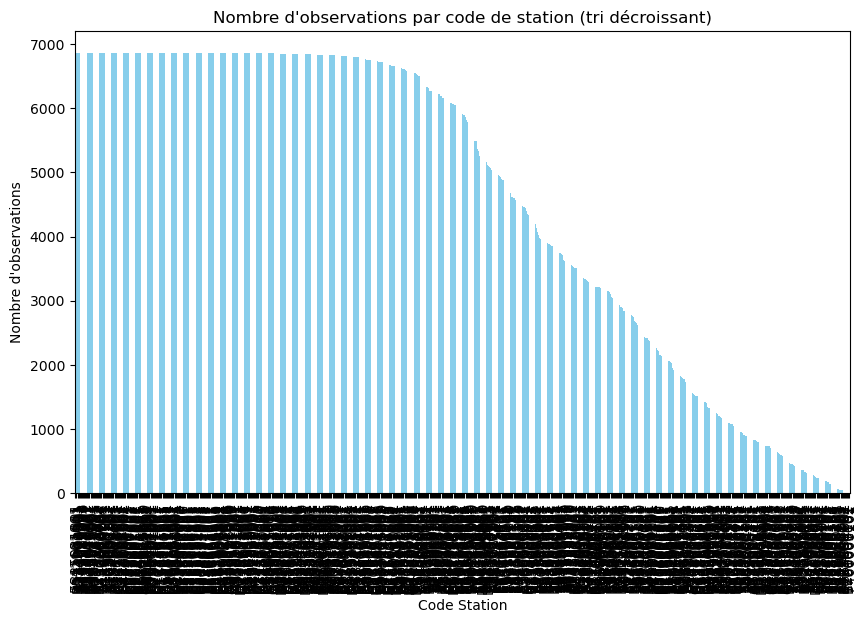

In [10]:

nb_values = df.groupby("code_station")["resultat_obs_elab"].count()
nb_values = nb_values.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
nb_values.plot(kind='bar', color='skyblue')

plt.xlabel('Code Station')
plt.ylabel('Nombre d\'observations')
plt.title('Nombre d\'observations par code de station (tri décroissant)')

plt.show()


In [33]:
# nb_values = df.groupby("code_station")["resultat_obs_elab"].count()
# big_station=nb_values[nb_values>5000]
# df = df[df["code_station"].isin(big_station.index)]

In [17]:
nb_values = df.groupby("code_station")["resultat_obs_elab"].count()
station=nb_values[nb_values>5000]

In [18]:
station.index

Index([  2501000101,   2503000101,   2521000102,   5041000101,   5221000101,
       '6020000101', '8032000101', '9104000101', 'A022020001', 'A041030001',
       ...
       'H514261001', 'H514262001', 'H515301001', 'H517201001', 'H517311001',
       'H520101003', 'H520421001', 'H521331001', 'H522431001', 'H524301001'],
      dtype='object', name='code_station', length=387)

# Fonctions de visualisaiton 

Pour visualiser les données

In [11]:
def visu(ts):
    nom_station = ts["libelle_station"].iloc[0]
    
    ts['date_obs_elab'] = pd.to_datetime(ts['date_obs_elab'])
    
    # Tracé d'un graphique temporel
    plt.figure(figsize=(15, 6))
    plt.plot(ts["date_obs_elab"], ts["resultat_obs_elab"], linewidth=3)
    plt.title(f'Stations {nom_station}')
    plt.show()

    # Histogramme
    fig = px.histogram(ts, x="resultat_obs_elab")
    fig.update_layout(title=f'Stations {nom_station}')
    fig.show()  

    # Box plot mensuel
    ts['Mois'] = ts['date_obs_elab'].dt.month_name()
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Mois', y='resultat_obs_elab', data=ts)
    plt.xlabel('Mois')
    plt.ylabel('Résultat Observation Elab')
    plt.title(f'Stations {nom_station}')
    plt.xticks(rotation=45)
    plt.show()



# Fonction de mise en forme

In [12]:
def mise_en_forme(ts):
    ts=ts[['date_obs_elab','resultat_obs_elab']]
    ts['date_obs_elab'] = pd.to_datetime(ts['date_obs_elab'])

    train_size = int(len(ts) * 0.8)
    train, test = ts[:train_size], ts[train_size:]
   
    train_r=train.rename(columns={'date_obs_elab':'ds',
                        'resultat_obs_elab':'y'})

    test_r=test.rename(columns={'date_obs_elab':'ds',
                        'resultat_obs_elab':'y'})
    return train_r, test_r

# Modele

Création du modèle, et on utilise le modèle sur la base test

In [13]:
# def model(train_r,test_r):
#     model = Prophet(
#     yearly_seasonality=12,  # Increase the number of Fourier terms
#     seasonality_prior_scale=0.8,  # Adjust the seasonality prior scale
#     )

#     model.fit(train_r)  
#     test_fcst = model.predict(df=test_r)

#     future_dates = model.make_future_dataframe(periods=6*12*30, freq='D')  
#     forecast = model.predict(future_dates)
#     return (model, test_fcst,forecast)

In [30]:
def model(train_r, test_r):
    model = Prophet(
        yearly_seasonality=12,  
        seasonality_prior_scale=0.8,
        changepoint_prior_scale=0.05,  # Ajuster le changepoint_prior_scale pour augmenter la sensibilité aux changements de tendance
    )
    model.uncertainty_samples = 1000  # Augmenter le nombre d'échantillons d'incertitude


    model.fit(train_r)
    
    test_fcst = model.predict(df=test_r)

    start_date = test_r['ds'].min()
    end_date = datetime.strptime("2024-01-01", "%Y-%m-%d")
    days_difference = (end_date - start_date).days

    future_dates = model.make_future_dataframe(periods=days_difference, freq='D')
    #future_dates = future_dates[future_dates['ds'].dt.year >= 2020]

    forecast = model.predict(future_dates)

    factor = 1.8  #  augmenter l'écart-type 
    forecast['yhat'] = forecast['yhat'] * factor  - forecast['trend']
    #forecast['yhat'] = forecast['yhat'] - forecast['trend'] enlever la trend
    
    
    # Filtrer les prévisions pour conserver uniquement celles supérieures à l'année 2022
    filtered_forecast = forecast[forecast['ds'].dt.year > 2022]
    
    return (model, test_fcst, forecast, filtered_forecast)


Visualisation des données forecaster du modèle

In [15]:
def visu_ts( test_r,test_fcst, model ):
    f, ax = plt.subplots(1)
    f.set_figheight(5)
    f.set_figwidth(15)
    ax.scatter(test_r["ds"], test_r['y'], color='r')
    fig = model.plot(test_fcst, ax=ax)

In [16]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def erreur(test_r, test_fcst):
    a=mean_absolute_percentage_error(y_true=test_r['y'],
                    y_pred=test_fcst['yhat'])
    b=mean_absolute_error(y_true=test_r['y'],
                    y_pred=test_fcst['yhat'])
    #print(f"Erreur moyenne absolue: {b} \nPOurcentage moyen de l'erreur absolue: {a}")
    return a
    

# Seuil

In [17]:
def visu_seuil( test_r,test_fcst, model, quantile,quantile_name ):
    
    f, ax = plt.subplots(1)
    f.set_figheight(5)
    f.set_figwidth(15)
    ax.scatter(test_r["ds"], test_r['y'], color='r', label='Données réelles')
    plt.axhline(y=quantile, color='y', linestyle='--', label=f'Quantile {quantile_name}: ({quantile:.2f})')
    ax.set_title('Visualisation des prévisions avec le seuil ')
    fig = model.plot(test_fcst, ax=ax)
    ax.legend()
    plt.show()

# Stations

In [18]:
#Choix de la station
data=df[df["code_station"]=="G400022010"]

In [19]:
def construction_ts(station, quantile):
    visu(station)

    #mise en forme et séparation train/test
    train,test=mise_en_forme(station)

    modele, prediction, pred_futur, pred_futur2 = model(train,test)

    a=erreur(test, prediction)

    
    quantile_80 = station["resultat_obs_elab"].quantile(quantile)
    visu_seuil( test,pred_futur, modele, quantile_80,quantile )

    count_over_quantile = (pred_futur2["yhat"] > quantile_80).sum()

    print(f"Nombre de fois où la hauteur est supérieur au quantile {quantile}, qui est de {quantile_80:.0f} mètres : {count_over_quantile} dans les {len(pred_futur2['yhat'])} prochain jours")

    return(pred_futur)



# Recuperation données

In [20]:
len(station)

710

In [34]:
result = []

In [35]:
n=0
for i in station:
    print(n)
    n=n+1
    dat=df[df['code_station']==i]
    train, test = mise_en_forme(dat)
    modele, prediction, pred_futur, pred_futur2 = model(train,test)
    jour=len(pred_futur2)
    
    
    
    erreur_abs=erreur(test, prediction)
    
    result.append({
        'station': i, 
         "nb_jour":jour,
         "erreur": erreur_abs, 
         "predictoins" : pred_futur2["yhat"]
    })


0


18:27:15 - cmdstanpy - INFO - Chain [1] start processing
18:27:16 - cmdstanpy - INFO - Chain [1] done processing


1


18:27:22 - cmdstanpy - INFO - Chain [1] start processing
18:27:22 - cmdstanpy - INFO - Chain [1] done processing


2


18:27:29 - cmdstanpy - INFO - Chain [1] start processing
18:27:30 - cmdstanpy - INFO - Chain [1] done processing


3


18:27:36 - cmdstanpy - INFO - Chain [1] start processing
18:27:36 - cmdstanpy - INFO - Chain [1] done processing


4


18:27:41 - cmdstanpy - INFO - Chain [1] start processing
18:27:41 - cmdstanpy - INFO - Chain [1] done processing


5


18:27:46 - cmdstanpy - INFO - Chain [1] start processing
18:27:47 - cmdstanpy - INFO - Chain [1] done processing


6


18:27:52 - cmdstanpy - INFO - Chain [1] start processing
18:27:53 - cmdstanpy - INFO - Chain [1] done processing


7


18:27:58 - cmdstanpy - INFO - Chain [1] start processing
18:27:59 - cmdstanpy - INFO - Chain [1] done processing


8


18:28:03 - cmdstanpy - INFO - Chain [1] start processing
18:28:04 - cmdstanpy - INFO - Chain [1] done processing


9


18:28:09 - cmdstanpy - INFO - Chain [1] start processing
18:28:09 - cmdstanpy - INFO - Chain [1] done processing


10


18:28:13 - cmdstanpy - INFO - Chain [1] start processing
18:28:13 - cmdstanpy - INFO - Chain [1] done processing


11


18:28:15 - cmdstanpy - INFO - Chain [1] start processing
18:28:15 - cmdstanpy - INFO - Chain [1] done processing


12


18:28:18 - cmdstanpy - INFO - Chain [1] start processing
18:28:18 - cmdstanpy - INFO - Chain [1] done processing


13


18:28:23 - cmdstanpy - INFO - Chain [1] start processing
18:28:23 - cmdstanpy - INFO - Chain [1] done processing


14


18:28:27 - cmdstanpy - INFO - Chain [1] start processing
18:28:27 - cmdstanpy - INFO - Chain [1] done processing


15


18:28:30 - cmdstanpy - INFO - Chain [1] start processing
18:28:31 - cmdstanpy - INFO - Chain [1] done processing


16


18:28:34 - cmdstanpy - INFO - Chain [1] start processing
18:28:35 - cmdstanpy - INFO - Chain [1] done processing


17


18:28:38 - cmdstanpy - INFO - Chain [1] start processing
18:28:39 - cmdstanpy - INFO - Chain [1] done processing


18


18:28:43 - cmdstanpy - INFO - Chain [1] start processing
18:28:44 - cmdstanpy - INFO - Chain [1] done processing


19


18:28:50 - cmdstanpy - INFO - Chain [1] start processing
18:28:52 - cmdstanpy - INFO - Chain [1] done processing


20


18:28:57 - cmdstanpy - INFO - Chain [1] start processing
18:28:58 - cmdstanpy - INFO - Chain [1] done processing


21


18:29:02 - cmdstanpy - INFO - Chain [1] start processing
18:29:02 - cmdstanpy - INFO - Chain [1] done processing


22


18:29:07 - cmdstanpy - INFO - Chain [1] start processing
18:29:09 - cmdstanpy - INFO - Chain [1] done processing


23


18:29:14 - cmdstanpy - INFO - Chain [1] start processing
18:29:15 - cmdstanpy - INFO - Chain [1] done processing


24


18:29:20 - cmdstanpy - INFO - Chain [1] start processing
18:29:21 - cmdstanpy - INFO - Chain [1] done processing


25


18:29:26 - cmdstanpy - INFO - Chain [1] start processing
18:29:27 - cmdstanpy - INFO - Chain [1] done processing


26


18:29:31 - cmdstanpy - INFO - Chain [1] start processing
18:29:31 - cmdstanpy - INFO - Chain [1] done processing


27


18:29:34 - cmdstanpy - INFO - Chain [1] start processing
18:29:35 - cmdstanpy - INFO - Chain [1] done processing


28


18:29:39 - cmdstanpy - INFO - Chain [1] start processing
18:29:40 - cmdstanpy - INFO - Chain [1] done processing


29


18:29:43 - cmdstanpy - INFO - Chain [1] start processing
18:29:44 - cmdstanpy - INFO - Chain [1] done processing


30


18:29:48 - cmdstanpy - INFO - Chain [1] start processing
18:29:49 - cmdstanpy - INFO - Chain [1] done processing


31


18:29:52 - cmdstanpy - INFO - Chain [1] start processing
18:29:53 - cmdstanpy - INFO - Chain [1] done processing


32


18:29:57 - cmdstanpy - INFO - Chain [1] start processing
18:29:58 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_1944\862629861.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


33


18:30:03 - cmdstanpy - INFO - Chain [1] start processing
18:30:03 - cmdstanpy - INFO - Chain [1] done processing


34


18:30:09 - cmdstanpy - INFO - Chain [1] start processing
18:30:09 - cmdstanpy - INFO - Chain [1] done processing


35


18:30:12 - cmdstanpy - INFO - Chain [1] start processing
18:30:13 - cmdstanpy - INFO - Chain [1] done processing


36


18:30:17 - cmdstanpy - INFO - Chain [1] start processing
18:30:18 - cmdstanpy - INFO - Chain [1] done processing


37


18:30:22 - cmdstanpy - INFO - Chain [1] start processing
18:30:22 - cmdstanpy - INFO - Chain [1] done processing


38


18:30:24 - cmdstanpy - INFO - Chain [1] start processing
18:30:24 - cmdstanpy - INFO - Chain [1] done processing


39


18:30:26 - cmdstanpy - INFO - Chain [1] start processing
18:30:26 - cmdstanpy - INFO - Chain [1] done processing


40


18:30:28 - cmdstanpy - INFO - Chain [1] start processing
18:30:28 - cmdstanpy - INFO - Chain [1] done processing


41


18:30:31 - cmdstanpy - INFO - Chain [1] start processing
18:30:31 - cmdstanpy - INFO - Chain [1] done processing


42


18:30:33 - cmdstanpy - INFO - Chain [1] start processing
18:30:33 - cmdstanpy - INFO - Chain [1] done processing


43


18:30:35 - cmdstanpy - INFO - Chain [1] start processing
18:30:36 - cmdstanpy - INFO - Chain [1] done processing


44


18:30:38 - cmdstanpy - INFO - Chain [1] start processing
18:30:38 - cmdstanpy - INFO - Chain [1] done processing


45


18:30:40 - cmdstanpy - INFO - Chain [1] start processing
18:30:40 - cmdstanpy - INFO - Chain [1] done processing


46


18:30:42 - cmdstanpy - INFO - Chain [1] start processing
18:30:42 - cmdstanpy - INFO - Chain [1] done processing


47


18:30:44 - cmdstanpy - INFO - Chain [1] start processing
18:30:44 - cmdstanpy - INFO - Chain [1] done processing


48


18:30:48 - cmdstanpy - INFO - Chain [1] start processing
18:30:50 - cmdstanpy - INFO - Chain [1] done processing


49


18:30:54 - cmdstanpy - INFO - Chain [1] start processing
18:30:55 - cmdstanpy - INFO - Chain [1] done processing


50


18:30:59 - cmdstanpy - INFO - Chain [1] start processing
18:30:59 - cmdstanpy - INFO - Chain [1] done processing


51


18:31:03 - cmdstanpy - INFO - Chain [1] start processing
18:31:03 - cmdstanpy - INFO - Chain [1] done processing


52


18:31:05 - cmdstanpy - INFO - Chain [1] start processing
18:31:06 - cmdstanpy - INFO - Chain [1] done processing


53


18:31:10 - cmdstanpy - INFO - Chain [1] start processing
18:31:10 - cmdstanpy - INFO - Chain [1] done processing


54


18:31:12 - cmdstanpy - INFO - Chain [1] start processing
18:31:12 - cmdstanpy - INFO - Chain [1] done processing


55


18:31:19 - cmdstanpy - INFO - Chain [1] start processing
18:31:20 - cmdstanpy - INFO - Chain [1] done processing


56


18:31:24 - cmdstanpy - INFO - Chain [1] start processing
18:31:24 - cmdstanpy - INFO - Chain [1] done processing


57


18:31:29 - cmdstanpy - INFO - Chain [1] start processing
18:31:30 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_1944\862629861.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


58


18:31:34 - cmdstanpy - INFO - Chain [1] start processing
18:31:35 - cmdstanpy - INFO - Chain [1] done processing


59


18:31:38 - cmdstanpy - INFO - Chain [1] start processing
18:31:38 - cmdstanpy - INFO - Chain [1] done processing


60


18:31:39 - cmdstanpy - INFO - Chain [1] start processing
18:31:40 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_1944\862629861.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


61


18:31:44 - cmdstanpy - INFO - Chain [1] start processing
18:31:46 - cmdstanpy - INFO - Chain [1] done processing


62


18:31:51 - cmdstanpy - INFO - Chain [1] start processing
18:31:55 - cmdstanpy - INFO - Chain [1] done processing


63


18:32:00 - cmdstanpy - INFO - Chain [1] start processing
18:32:00 - cmdstanpy - INFO - Chain [1] done processing


64


18:32:02 - cmdstanpy - INFO - Chain [1] start processing
18:32:03 - cmdstanpy - INFO - Chain [1] done processing


65


18:32:08 - cmdstanpy - INFO - Chain [1] start processing
18:32:12 - cmdstanpy - INFO - Chain [1] done processing


66


18:32:17 - cmdstanpy - INFO - Chain [1] start processing
18:32:18 - cmdstanpy - INFO - Chain [1] done processing


67


18:32:22 - cmdstanpy - INFO - Chain [1] start processing
18:32:23 - cmdstanpy - INFO - Chain [1] done processing


68


18:32:27 - cmdstanpy - INFO - Chain [1] start processing
18:32:27 - cmdstanpy - INFO - Chain [1] done processing


69


18:32:33 - cmdstanpy - INFO - Chain [1] start processing
18:32:34 - cmdstanpy - INFO - Chain [1] done processing


70


18:32:37 - cmdstanpy - INFO - Chain [1] start processing
18:32:38 - cmdstanpy - INFO - Chain [1] done processing


71


18:32:41 - cmdstanpy - INFO - Chain [1] start processing
18:32:44 - cmdstanpy - INFO - Chain [1] done processing


72


18:32:50 - cmdstanpy - INFO - Chain [1] start processing
18:32:51 - cmdstanpy - INFO - Chain [1] done processing


73


18:32:54 - cmdstanpy - INFO - Chain [1] start processing
18:32:55 - cmdstanpy - INFO - Chain [1] done processing


74


18:32:58 - cmdstanpy - INFO - Chain [1] start processing
18:32:59 - cmdstanpy - INFO - Chain [1] done processing


75


18:33:03 - cmdstanpy - INFO - Chain [1] start processing
18:33:03 - cmdstanpy - INFO - Chain [1] done processing


76


18:33:09 - cmdstanpy - INFO - Chain [1] start processing
18:33:11 - cmdstanpy - INFO - Chain [1] done processing


77


18:33:17 - cmdstanpy - INFO - Chain [1] start processing
18:33:18 - cmdstanpy - INFO - Chain [1] done processing


78


18:33:23 - cmdstanpy - INFO - Chain [1] start processing
18:33:24 - cmdstanpy - INFO - Chain [1] done processing


79


18:33:26 - cmdstanpy - INFO - Chain [1] start processing
18:33:27 - cmdstanpy - INFO - Chain [1] done processing


80


18:33:30 - cmdstanpy - INFO - Chain [1] start processing
18:33:30 - cmdstanpy - INFO - Chain [1] done processing


81


18:33:32 - cmdstanpy - INFO - Chain [1] start processing
18:33:33 - cmdstanpy - INFO - Chain [1] done processing


82


18:33:36 - cmdstanpy - INFO - Chain [1] start processing
18:33:36 - cmdstanpy - INFO - Chain [1] done processing


83


18:33:41 - cmdstanpy - INFO - Chain [1] start processing
18:33:42 - cmdstanpy - INFO - Chain [1] done processing


84


18:33:46 - cmdstanpy - INFO - Chain [1] start processing
18:33:49 - cmdstanpy - INFO - Chain [1] done processing


85


18:33:55 - cmdstanpy - INFO - Chain [1] start processing
18:33:58 - cmdstanpy - INFO - Chain [1] done processing


86


18:34:03 - cmdstanpy - INFO - Chain [1] start processing
18:34:04 - cmdstanpy - INFO - Chain [1] done processing


87


18:34:09 - cmdstanpy - INFO - Chain [1] start processing
18:34:11 - cmdstanpy - INFO - Chain [1] done processing


88


18:34:16 - cmdstanpy - INFO - Chain [1] start processing
18:34:16 - cmdstanpy - INFO - Chain [1] done processing


89


18:34:22 - cmdstanpy - INFO - Chain [1] start processing
18:34:22 - cmdstanpy - INFO - Chain [1] done processing


90


18:34:27 - cmdstanpy - INFO - Chain [1] start processing
18:34:27 - cmdstanpy - INFO - Chain [1] done processing


91


18:34:29 - cmdstanpy - INFO - Chain [1] start processing
18:34:30 - cmdstanpy - INFO - Chain [1] done processing


92


18:34:33 - cmdstanpy - INFO - Chain [1] start processing
18:34:34 - cmdstanpy - INFO - Chain [1] done processing


93


18:34:38 - cmdstanpy - INFO - Chain [1] start processing
18:34:39 - cmdstanpy - INFO - Chain [1] done processing


94


18:34:44 - cmdstanpy - INFO - Chain [1] start processing
18:34:46 - cmdstanpy - INFO - Chain [1] done processing


95


18:34:52 - cmdstanpy - INFO - Chain [1] start processing
18:34:55 - cmdstanpy - INFO - Chain [1] done processing


96


18:35:02 - cmdstanpy - INFO - Chain [1] start processing
18:35:04 - cmdstanpy - INFO - Chain [1] done processing


97


18:35:10 - cmdstanpy - INFO - Chain [1] start processing
18:35:11 - cmdstanpy - INFO - Chain [1] done processing


98


18:35:17 - cmdstanpy - INFO - Chain [1] start processing
18:35:17 - cmdstanpy - INFO - Chain [1] done processing


99


18:35:20 - cmdstanpy - INFO - Chain [1] start processing
18:35:20 - cmdstanpy - INFO - Chain [1] done processing


100


18:35:26 - cmdstanpy - INFO - Chain [1] start processing
18:35:26 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_1944\862629861.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


101


18:35:30 - cmdstanpy - INFO - Chain [1] start processing
18:35:32 - cmdstanpy - INFO - Chain [1] done processing


102


18:35:38 - cmdstanpy - INFO - Chain [1] start processing
18:35:40 - cmdstanpy - INFO - Chain [1] done processing


103


18:35:45 - cmdstanpy - INFO - Chain [1] start processing
18:35:45 - cmdstanpy - INFO - Chain [1] done processing


104


18:35:47 - cmdstanpy - INFO - Chain [1] start processing
18:35:47 - cmdstanpy - INFO - Chain [1] done processing


105


18:35:51 - cmdstanpy - INFO - Chain [1] start processing
18:35:52 - cmdstanpy - INFO - Chain [1] done processing


106


18:35:58 - cmdstanpy - INFO - Chain [1] start processing
18:35:58 - cmdstanpy - INFO - Chain [1] done processing


107


18:36:01 - cmdstanpy - INFO - Chain [1] start processing
18:36:01 - cmdstanpy - INFO - Chain [1] done processing


108


18:36:07 - cmdstanpy - INFO - Chain [1] start processing
18:36:08 - cmdstanpy - INFO - Chain [1] done processing


109


18:36:14 - cmdstanpy - INFO - Chain [1] start processing
18:36:16 - cmdstanpy - INFO - Chain [1] done processing


110


18:36:21 - cmdstanpy - INFO - Chain [1] start processing
18:36:22 - cmdstanpy - INFO - Chain [1] done processing


111


18:36:26 - cmdstanpy - INFO - Chain [1] start processing
18:36:28 - cmdstanpy - INFO - Chain [1] done processing


112


18:36:33 - cmdstanpy - INFO - Chain [1] start processing
18:36:33 - cmdstanpy - INFO - Chain [1] done processing


113


18:36:36 - cmdstanpy - INFO - Chain [1] start processing
18:36:38 - cmdstanpy - INFO - Chain [1] done processing


114


18:36:43 - cmdstanpy - INFO - Chain [1] start processing
18:36:45 - cmdstanpy - INFO - Chain [1] done processing


115


18:36:51 - cmdstanpy - INFO - Chain [1] start processing
18:36:53 - cmdstanpy - INFO - Chain [1] done processing


116


18:36:59 - cmdstanpy - INFO - Chain [1] start processing
18:37:01 - cmdstanpy - INFO - Chain [1] done processing


117


18:37:06 - cmdstanpy - INFO - Chain [1] start processing
18:37:06 - cmdstanpy - INFO - Chain [1] done processing


118


18:37:09 - cmdstanpy - INFO - Chain [1] start processing
18:37:11 - cmdstanpy - INFO - Chain [1] done processing


119


18:37:17 - cmdstanpy - INFO - Chain [1] start processing
18:37:18 - cmdstanpy - INFO - Chain [1] done processing


120


18:37:24 - cmdstanpy - INFO - Chain [1] start processing
18:37:24 - cmdstanpy - INFO - Chain [1] done processing


121


18:37:28 - cmdstanpy - INFO - Chain [1] start processing
18:37:30 - cmdstanpy - INFO - Chain [1] done processing


122


18:37:36 - cmdstanpy - INFO - Chain [1] start processing
18:37:37 - cmdstanpy - INFO - Chain [1] done processing


123


18:37:43 - cmdstanpy - INFO - Chain [1] start processing
18:37:45 - cmdstanpy - INFO - Chain [1] done processing


124


18:37:50 - cmdstanpy - INFO - Chain [1] start processing
18:37:51 - cmdstanpy - INFO - Chain [1] done processing


125


18:37:54 - cmdstanpy - INFO - Chain [1] start processing
18:37:54 - cmdstanpy - INFO - Chain [1] done processing


126


18:38:01 - cmdstanpy - INFO - Chain [1] start processing
18:38:02 - cmdstanpy - INFO - Chain [1] done processing


127


18:38:06 - cmdstanpy - INFO - Chain [1] start processing
18:38:06 - cmdstanpy - INFO - Chain [1] done processing


128


18:38:08 - cmdstanpy - INFO - Chain [1] start processing
18:38:08 - cmdstanpy - INFO - Chain [1] done processing


129


18:38:11 - cmdstanpy - INFO - Chain [1] start processing
18:38:12 - cmdstanpy - INFO - Chain [1] done processing


130


18:38:18 - cmdstanpy - INFO - Chain [1] start processing
18:38:19 - cmdstanpy - INFO - Chain [1] done processing


131


18:38:23 - cmdstanpy - INFO - Chain [1] start processing
18:38:23 - cmdstanpy - INFO - Chain [1] done processing


132


18:38:30 - cmdstanpy - INFO - Chain [1] start processing
18:38:32 - cmdstanpy - INFO - Chain [1] done processing


133


18:38:37 - cmdstanpy - INFO - Chain [1] start processing
18:38:37 - cmdstanpy - INFO - Chain [1] done processing


134


18:38:40 - cmdstanpy - INFO - Chain [1] start processing
18:38:40 - cmdstanpy - INFO - Chain [1] done processing


135


18:38:41 - cmdstanpy - INFO - Chain [1] start processing
18:38:42 - cmdstanpy - INFO - Chain [1] done processing


136


18:38:43 - cmdstanpy - INFO - Chain [1] start processing
18:38:43 - cmdstanpy - INFO - Chain [1] done processing


137


18:38:46 - cmdstanpy - INFO - Chain [1] start processing
18:38:47 - cmdstanpy - INFO - Chain [1] done processing


138


18:38:54 - cmdstanpy - INFO - Chain [1] start processing
18:38:55 - cmdstanpy - INFO - Chain [1] done processing


139


18:39:01 - cmdstanpy - INFO - Chain [1] start processing
18:39:02 - cmdstanpy - INFO - Chain [1] done processing


140


18:39:03 - cmdstanpy - INFO - Chain [1] start processing
18:39:03 - cmdstanpy - INFO - Chain [1] done processing


141


18:39:05 - cmdstanpy - INFO - Chain [1] start processing
18:39:09 - cmdstanpy - INFO - Chain [1] done processing


142


18:39:15 - cmdstanpy - INFO - Chain [1] start processing
18:39:16 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_1944\862629861.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


143


18:39:25 - cmdstanpy - INFO - Chain [1] start processing
18:39:27 - cmdstanpy - INFO - Chain [1] done processing


144


18:39:31 - cmdstanpy - INFO - Chain [1] start processing
18:39:33 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_1944\862629861.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


145


18:39:37 - cmdstanpy - INFO - Chain [1] start processing
18:39:37 - cmdstanpy - INFO - Chain [1] done processing


146


18:39:46 - cmdstanpy - INFO - Chain [1] start processing
18:39:47 - cmdstanpy - INFO - Chain [1] done processing


147


18:39:52 - cmdstanpy - INFO - Chain [1] start processing
18:39:53 - cmdstanpy - INFO - Chain [1] done processing


148


18:39:58 - cmdstanpy - INFO - Chain [1] start processing
18:39:58 - cmdstanpy - INFO - Chain [1] done processing


149


18:40:04 - cmdstanpy - INFO - Chain [1] start processing
18:40:06 - cmdstanpy - INFO - Chain [1] done processing


150


18:40:11 - cmdstanpy - INFO - Chain [1] start processing
18:40:14 - cmdstanpy - INFO - Chain [1] done processing


151


18:40:20 - cmdstanpy - INFO - Chain [1] start processing
18:40:21 - cmdstanpy - INFO - Chain [1] done processing


152


18:40:28 - cmdstanpy - INFO - Chain [1] start processing
18:40:29 - cmdstanpy - INFO - Chain [1] done processing


153


18:40:36 - cmdstanpy - INFO - Chain [1] start processing
18:40:37 - cmdstanpy - INFO - Chain [1] done processing


154


18:40:44 - cmdstanpy - INFO - Chain [1] start processing
18:40:46 - cmdstanpy - INFO - Chain [1] done processing


155


18:40:52 - cmdstanpy - INFO - Chain [1] start processing
18:40:53 - cmdstanpy - INFO - Chain [1] done processing


156


18:40:59 - cmdstanpy - INFO - Chain [1] start processing
18:41:02 - cmdstanpy - INFO - Chain [1] done processing


157


18:41:08 - cmdstanpy - INFO - Chain [1] start processing
18:41:09 - cmdstanpy - INFO - Chain [1] done processing


158


18:41:14 - cmdstanpy - INFO - Chain [1] start processing
18:41:15 - cmdstanpy - INFO - Chain [1] done processing


159


18:41:19 - cmdstanpy - INFO - Chain [1] start processing
18:41:20 - cmdstanpy - INFO - Chain [1] done processing


160


18:41:26 - cmdstanpy - INFO - Chain [1] start processing
18:41:28 - cmdstanpy - INFO - Chain [1] done processing


161


18:41:34 - cmdstanpy - INFO - Chain [1] start processing
18:41:35 - cmdstanpy - INFO - Chain [1] done processing


162


18:41:42 - cmdstanpy - INFO - Chain [1] start processing
18:41:43 - cmdstanpy - INFO - Chain [1] done processing


163


18:41:50 - cmdstanpy - INFO - Chain [1] start processing
18:41:53 - cmdstanpy - INFO - Chain [1] done processing


164


18:41:59 - cmdstanpy - INFO - Chain [1] start processing
18:42:01 - cmdstanpy - INFO - Chain [1] done processing


165


18:42:07 - cmdstanpy - INFO - Chain [1] start processing
18:42:07 - cmdstanpy - INFO - Chain [1] done processing


166


18:42:12 - cmdstanpy - INFO - Chain [1] start processing
18:42:14 - cmdstanpy - INFO - Chain [1] done processing


167


18:42:20 - cmdstanpy - INFO - Chain [1] start processing
18:42:23 - cmdstanpy - INFO - Chain [1] done processing


168


18:42:29 - cmdstanpy - INFO - Chain [1] start processing
18:42:31 - cmdstanpy - INFO - Chain [1] done processing


169


18:42:36 - cmdstanpy - INFO - Chain [1] start processing
18:42:37 - cmdstanpy - INFO - Chain [1] done processing


170


18:42:41 - cmdstanpy - INFO - Chain [1] start processing
18:42:42 - cmdstanpy - INFO - Chain [1] done processing


171


18:42:48 - cmdstanpy - INFO - Chain [1] start processing
18:42:49 - cmdstanpy - INFO - Chain [1] done processing


172


18:42:54 - cmdstanpy - INFO - Chain [1] start processing
18:42:55 - cmdstanpy - INFO - Chain [1] done processing


173


18:43:01 - cmdstanpy - INFO - Chain [1] start processing
18:43:02 - cmdstanpy - INFO - Chain [1] done processing


174


18:43:07 - cmdstanpy - INFO - Chain [1] start processing
18:43:07 - cmdstanpy - INFO - Chain [1] done processing


175


18:43:12 - cmdstanpy - INFO - Chain [1] start processing
18:43:13 - cmdstanpy - INFO - Chain [1] done processing


176


18:43:19 - cmdstanpy - INFO - Chain [1] start processing
18:43:21 - cmdstanpy - INFO - Chain [1] done processing


177


18:43:25 - cmdstanpy - INFO - Chain [1] start processing
18:43:27 - cmdstanpy - INFO - Chain [1] done processing


178


18:43:29 - cmdstanpy - INFO - Chain [1] start processing
18:43:30 - cmdstanpy - INFO - Chain [1] done processing


179


18:43:36 - cmdstanpy - INFO - Chain [1] start processing
18:43:37 - cmdstanpy - INFO - Chain [1] done processing


180


18:43:43 - cmdstanpy - INFO - Chain [1] start processing
18:43:44 - cmdstanpy - INFO - Chain [1] done processing


181


18:43:49 - cmdstanpy - INFO - Chain [1] start processing
18:43:50 - cmdstanpy - INFO - Chain [1] done processing


182


18:43:53 - cmdstanpy - INFO - Chain [1] start processing
18:43:54 - cmdstanpy - INFO - Chain [1] done processing


183


18:43:59 - cmdstanpy - INFO - Chain [1] start processing
18:43:59 - cmdstanpy - INFO - Chain [1] done processing


184


18:44:03 - cmdstanpy - INFO - Chain [1] start processing
18:44:04 - cmdstanpy - INFO - Chain [1] done processing


185


18:44:05 - cmdstanpy - INFO - Chain [1] start processing
18:44:06 - cmdstanpy - INFO - Chain [1] done processing


186


18:44:10 - cmdstanpy - INFO - Chain [1] start processing
18:44:11 - cmdstanpy - INFO - Chain [1] done processing


187


18:44:15 - cmdstanpy - INFO - Chain [1] start processing
18:44:16 - cmdstanpy - INFO - Chain [1] done processing


188


18:44:22 - cmdstanpy - INFO - Chain [1] start processing
18:44:23 - cmdstanpy - INFO - Chain [1] done processing


189


18:44:27 - cmdstanpy - INFO - Chain [1] start processing
18:44:28 - cmdstanpy - INFO - Chain [1] done processing


190


18:44:33 - cmdstanpy - INFO - Chain [1] start processing
18:44:33 - cmdstanpy - INFO - Chain [1] done processing


191


18:44:37 - cmdstanpy - INFO - Chain [1] start processing
18:44:37 - cmdstanpy - INFO - Chain [1] done processing


192


18:44:42 - cmdstanpy - INFO - Chain [1] start processing
18:44:42 - cmdstanpy - INFO - Chain [1] done processing


193


18:44:45 - cmdstanpy - INFO - Chain [1] start processing
18:44:46 - cmdstanpy - INFO - Chain [1] done processing


194


18:44:51 - cmdstanpy - INFO - Chain [1] start processing
18:44:52 - cmdstanpy - INFO - Chain [1] done processing


195


18:44:57 - cmdstanpy - INFO - Chain [1] start processing
18:44:57 - cmdstanpy - INFO - Chain [1] done processing


196


18:45:03 - cmdstanpy - INFO - Chain [1] start processing
18:45:04 - cmdstanpy - INFO - Chain [1] done processing


197


18:45:10 - cmdstanpy - INFO - Chain [1] start processing
18:45:10 - cmdstanpy - INFO - Chain [1] done processing


198


18:45:16 - cmdstanpy - INFO - Chain [1] start processing
18:45:17 - cmdstanpy - INFO - Chain [1] done processing


199


18:45:23 - cmdstanpy - INFO - Chain [1] start processing
18:45:24 - cmdstanpy - INFO - Chain [1] done processing


200


18:45:30 - cmdstanpy - INFO - Chain [1] start processing
18:45:32 - cmdstanpy - INFO - Chain [1] done processing


201


18:45:36 - cmdstanpy - INFO - Chain [1] start processing
18:45:37 - cmdstanpy - INFO - Chain [1] done processing


202


18:45:41 - cmdstanpy - INFO - Chain [1] start processing
18:45:42 - cmdstanpy - INFO - Chain [1] done processing


203


18:45:46 - cmdstanpy - INFO - Chain [1] start processing
18:45:47 - cmdstanpy - INFO - Chain [1] done processing


204


18:45:52 - cmdstanpy - INFO - Chain [1] start processing
18:45:52 - cmdstanpy - INFO - Chain [1] done processing


205


18:45:56 - cmdstanpy - INFO - Chain [1] start processing
18:45:56 - cmdstanpy - INFO - Chain [1] done processing


206


18:46:02 - cmdstanpy - INFO - Chain [1] start processing
18:46:04 - cmdstanpy - INFO - Chain [1] done processing


207


18:46:09 - cmdstanpy - INFO - Chain [1] start processing
18:46:09 - cmdstanpy - INFO - Chain [1] done processing


208


18:46:16 - cmdstanpy - INFO - Chain [1] start processing
18:46:16 - cmdstanpy - INFO - Chain [1] done processing


209


18:46:23 - cmdstanpy - INFO - Chain [1] start processing
18:46:26 - cmdstanpy - INFO - Chain [1] done processing


210


18:46:31 - cmdstanpy - INFO - Chain [1] start processing
18:46:31 - cmdstanpy - INFO - Chain [1] done processing


211


18:46:37 - cmdstanpy - INFO - Chain [1] start processing
18:46:38 - cmdstanpy - INFO - Chain [1] done processing


212


18:46:43 - cmdstanpy - INFO - Chain [1] start processing
18:46:44 - cmdstanpy - INFO - Chain [1] done processing


213


18:46:48 - cmdstanpy - INFO - Chain [1] start processing
18:46:48 - cmdstanpy - INFO - Chain [1] done processing
18:46:52 - cmdstanpy - INFO - Chain [1] start processing


214


18:46:59 - cmdstanpy - INFO - Chain [1] done processing


215


18:47:01 - cmdstanpy - INFO - Chain [1] start processing
18:47:01 - cmdstanpy - INFO - Chain [1] done processing


216


18:47:07 - cmdstanpy - INFO - Chain [1] start processing
18:47:08 - cmdstanpy - INFO - Chain [1] done processing


217


18:47:14 - cmdstanpy - INFO - Chain [1] start processing
18:47:16 - cmdstanpy - INFO - Chain [1] done processing


218


18:47:21 - cmdstanpy - INFO - Chain [1] start processing
18:47:23 - cmdstanpy - INFO - Chain [1] done processing
18:47:27 - cmdstanpy - INFO - Chain [1] start processing


219


18:47:27 - cmdstanpy - INFO - Chain [1] done processing


220


18:47:32 - cmdstanpy - INFO - Chain [1] start processing
18:47:32 - cmdstanpy - INFO - Chain [1] done processing


221


18:47:35 - cmdstanpy - INFO - Chain [1] start processing
18:47:36 - cmdstanpy - INFO - Chain [1] done processing


222


18:47:42 - cmdstanpy - INFO - Chain [1] start processing
18:47:43 - cmdstanpy - INFO - Chain [1] done processing


223


18:47:48 - cmdstanpy - INFO - Chain [1] start processing
18:47:48 - cmdstanpy - INFO - Chain [1] done processing


224


18:47:51 - cmdstanpy - INFO - Chain [1] start processing
18:47:52 - cmdstanpy - INFO - Chain [1] done processing


225


18:47:56 - cmdstanpy - INFO - Chain [1] start processing
18:47:56 - cmdstanpy - INFO - Chain [1] done processing


226


18:48:02 - cmdstanpy - INFO - Chain [1] start processing
18:48:03 - cmdstanpy - INFO - Chain [1] done processing


227


18:48:09 - cmdstanpy - INFO - Chain [1] start processing
18:48:10 - cmdstanpy - INFO - Chain [1] done processing


228


18:48:14 - cmdstanpy - INFO - Chain [1] start processing
18:48:15 - cmdstanpy - INFO - Chain [1] done processing


229


18:48:20 - cmdstanpy - INFO - Chain [1] start processing
18:48:22 - cmdstanpy - INFO - Chain [1] done processing


230


18:48:27 - cmdstanpy - INFO - Chain [1] start processing
18:48:27 - cmdstanpy - INFO - Chain [1] done processing


231


18:48:30 - cmdstanpy - INFO - Chain [1] start processing
18:48:30 - cmdstanpy - INFO - Chain [1] done processing


232


18:48:31 - cmdstanpy - INFO - Chain [1] start processing
18:48:31 - cmdstanpy - INFO - Chain [1] done processing


233


18:48:34 - cmdstanpy - INFO - Chain [1] start processing
18:48:36 - cmdstanpy - INFO - Chain [1] done processing


234


18:48:41 - cmdstanpy - INFO - Chain [1] start processing
18:48:41 - cmdstanpy - INFO - Chain [1] done processing


235


18:48:45 - cmdstanpy - INFO - Chain [1] start processing
18:48:46 - cmdstanpy - INFO - Chain [1] done processing


236


18:48:52 - cmdstanpy - INFO - Chain [1] start processing
18:48:53 - cmdstanpy - INFO - Chain [1] done processing


237


18:48:58 - cmdstanpy - INFO - Chain [1] start processing
18:48:58 - cmdstanpy - INFO - Chain [1] done processing


238


18:49:03 - cmdstanpy - INFO - Chain [1] start processing
18:49:04 - cmdstanpy - INFO - Chain [1] done processing


239


18:49:07 - cmdstanpy - INFO - Chain [1] start processing
18:49:07 - cmdstanpy - INFO - Chain [1] done processing


240


18:49:12 - cmdstanpy - INFO - Chain [1] start processing
18:49:13 - cmdstanpy - INFO - Chain [1] done processing


241


18:49:16 - cmdstanpy - INFO - Chain [1] start processing
18:49:17 - cmdstanpy - INFO - Chain [1] done processing


242


18:49:23 - cmdstanpy - INFO - Chain [1] start processing
18:49:24 - cmdstanpy - INFO - Chain [1] done processing


243


18:49:30 - cmdstanpy - INFO - Chain [1] start processing
18:49:31 - cmdstanpy - INFO - Chain [1] done processing


244


18:49:36 - cmdstanpy - INFO - Chain [1] start processing
18:49:36 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_1944\862629861.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


245


18:49:40 - cmdstanpy - INFO - Chain [1] start processing
18:49:41 - cmdstanpy - INFO - Chain [1] done processing


246


18:49:46 - cmdstanpy - INFO - Chain [1] start processing
18:49:47 - cmdstanpy - INFO - Chain [1] done processing


247


18:49:52 - cmdstanpy - INFO - Chain [1] start processing
18:49:52 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_1944\862629861.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


248


18:49:55 - cmdstanpy - INFO - Chain [1] start processing
18:49:56 - cmdstanpy - INFO - Chain [1] done processing


249


18:49:59 - cmdstanpy - INFO - Chain [1] start processing
18:50:00 - cmdstanpy - INFO - Chain [1] done processing


250


18:50:06 - cmdstanpy - INFO - Chain [1] start processing
18:50:07 - cmdstanpy - INFO - Chain [1] done processing


251


18:50:11 - cmdstanpy - INFO - Chain [1] start processing
18:50:12 - cmdstanpy - INFO - Chain [1] done processing


252


18:50:14 - cmdstanpy - INFO - Chain [1] start processing
18:50:15 - cmdstanpy - INFO - Chain [1] done processing


253


18:50:21 - cmdstanpy - INFO - Chain [1] start processing
18:50:22 - cmdstanpy - INFO - Chain [1] done processing


254


18:50:27 - cmdstanpy - INFO - Chain [1] start processing
18:50:27 - cmdstanpy - INFO - Chain [1] done processing


255


18:50:31 - cmdstanpy - INFO - Chain [1] start processing
18:50:32 - cmdstanpy - INFO - Chain [1] done processing


256


18:50:35 - cmdstanpy - INFO - Chain [1] start processing
18:50:37 - cmdstanpy - INFO - Chain [1] done processing


257


18:50:41 - cmdstanpy - INFO - Chain [1] start processing
18:50:42 - cmdstanpy - INFO - Chain [1] done processing


258


18:50:46 - cmdstanpy - INFO - Chain [1] start processing
18:50:47 - cmdstanpy - INFO - Chain [1] done processing


259


18:50:51 - cmdstanpy - INFO - Chain [1] start processing
18:50:51 - cmdstanpy - INFO - Chain [1] done processing


260


18:50:56 - cmdstanpy - INFO - Chain [1] start processing
18:50:57 - cmdstanpy - INFO - Chain [1] done processing


261


18:51:01 - cmdstanpy - INFO - Chain [1] start processing
18:51:02 - cmdstanpy - INFO - Chain [1] done processing


262


18:51:08 - cmdstanpy - INFO - Chain [1] start processing
18:51:09 - cmdstanpy - INFO - Chain [1] done processing


263


18:51:15 - cmdstanpy - INFO - Chain [1] start processing
18:51:16 - cmdstanpy - INFO - Chain [1] done processing


264


18:51:20 - cmdstanpy - INFO - Chain [1] start processing
18:51:22 - cmdstanpy - INFO - Chain [1] done processing


265


18:51:27 - cmdstanpy - INFO - Chain [1] start processing
18:51:27 - cmdstanpy - INFO - Chain [1] done processing


266


18:51:31 - cmdstanpy - INFO - Chain [1] start processing
18:51:32 - cmdstanpy - INFO - Chain [1] done processing


267


18:51:37 - cmdstanpy - INFO - Chain [1] start processing
18:51:38 - cmdstanpy - INFO - Chain [1] done processing


268


18:51:45 - cmdstanpy - INFO - Chain [1] start processing
18:51:47 - cmdstanpy - INFO - Chain [1] done processing


269


18:51:53 - cmdstanpy - INFO - Chain [1] start processing
18:51:54 - cmdstanpy - INFO - Chain [1] done processing


270


18:51:59 - cmdstanpy - INFO - Chain [1] start processing
18:52:00 - cmdstanpy - INFO - Chain [1] done processing


271


18:52:06 - cmdstanpy - INFO - Chain [1] start processing
18:52:07 - cmdstanpy - INFO - Chain [1] done processing


272


18:52:13 - cmdstanpy - INFO - Chain [1] start processing
18:52:14 - cmdstanpy - INFO - Chain [1] done processing


273


18:52:21 - cmdstanpy - INFO - Chain [1] start processing
18:52:23 - cmdstanpy - INFO - Chain [1] done processing


274


18:52:29 - cmdstanpy - INFO - Chain [1] start processing
18:52:29 - cmdstanpy - INFO - Chain [1] done processing


275


18:52:34 - cmdstanpy - INFO - Chain [1] start processing
18:52:35 - cmdstanpy - INFO - Chain [1] done processing


276


18:52:40 - cmdstanpy - INFO - Chain [1] start processing
18:52:40 - cmdstanpy - INFO - Chain [1] done processing


277


18:52:45 - cmdstanpy - INFO - Chain [1] start processing
18:52:46 - cmdstanpy - INFO - Chain [1] done processing


278


18:52:51 - cmdstanpy - INFO - Chain [1] start processing
18:52:52 - cmdstanpy - INFO - Chain [1] done processing


279


18:52:55 - cmdstanpy - INFO - Chain [1] start processing
18:52:56 - cmdstanpy - INFO - Chain [1] done processing


280


18:52:59 - cmdstanpy - INFO - Chain [1] start processing
18:53:00 - cmdstanpy - INFO - Chain [1] done processing


281


18:53:04 - cmdstanpy - INFO - Chain [1] start processing
18:53:05 - cmdstanpy - INFO - Chain [1] done processing


282


18:53:08 - cmdstanpy - INFO - Chain [1] start processing
18:53:08 - cmdstanpy - INFO - Chain [1] done processing


283


18:53:10 - cmdstanpy - INFO - Chain [1] start processing
18:53:11 - cmdstanpy - INFO - Chain [1] done processing


284


18:53:14 - cmdstanpy - INFO - Chain [1] start processing
18:53:15 - cmdstanpy - INFO - Chain [1] done processing


285


18:53:19 - cmdstanpy - INFO - Chain [1] start processing
18:53:19 - cmdstanpy - INFO - Chain [1] done processing


286


18:53:24 - cmdstanpy - INFO - Chain [1] start processing
18:53:26 - cmdstanpy - INFO - Chain [1] done processing


287


18:53:31 - cmdstanpy - INFO - Chain [1] start processing
18:53:32 - cmdstanpy - INFO - Chain [1] done processing


288


18:53:40 - cmdstanpy - INFO - Chain [1] start processing
18:53:41 - cmdstanpy - INFO - Chain [1] done processing


289


18:53:47 - cmdstanpy - INFO - Chain [1] start processing
18:53:48 - cmdstanpy - INFO - Chain [1] done processing


290


18:53:53 - cmdstanpy - INFO - Chain [1] start processing
18:53:54 - cmdstanpy - INFO - Chain [1] done processing


291


18:54:00 - cmdstanpy - INFO - Chain [1] start processing
18:54:01 - cmdstanpy - INFO - Chain [1] done processing


292


18:54:05 - cmdstanpy - INFO - Chain [1] start processing
18:54:05 - cmdstanpy - INFO - Chain [1] done processing


293


18:54:11 - cmdstanpy - INFO - Chain [1] start processing
18:54:13 - cmdstanpy - INFO - Chain [1] done processing


294


18:54:18 - cmdstanpy - INFO - Chain [1] start processing
18:54:19 - cmdstanpy - INFO - Chain [1] done processing


295


18:54:25 - cmdstanpy - INFO - Chain [1] start processing
18:54:26 - cmdstanpy - INFO - Chain [1] done processing


296


18:54:31 - cmdstanpy - INFO - Chain [1] start processing
18:54:33 - cmdstanpy - INFO - Chain [1] done processing


297


18:54:38 - cmdstanpy - INFO - Chain [1] start processing
18:54:40 - cmdstanpy - INFO - Chain [1] done processing


298


18:54:45 - cmdstanpy - INFO - Chain [1] start processing
18:54:46 - cmdstanpy - INFO - Chain [1] done processing


299


18:54:51 - cmdstanpy - INFO - Chain [1] start processing
18:54:52 - cmdstanpy - INFO - Chain [1] done processing


300


18:54:57 - cmdstanpy - INFO - Chain [1] start processing
18:54:58 - cmdstanpy - INFO - Chain [1] done processing


301


18:55:04 - cmdstanpy - INFO - Chain [1] start processing
18:55:05 - cmdstanpy - INFO - Chain [1] done processing


302


18:55:10 - cmdstanpy - INFO - Chain [1] start processing
18:55:11 - cmdstanpy - INFO - Chain [1] done processing


303


18:55:14 - cmdstanpy - INFO - Chain [1] start processing
18:55:14 - cmdstanpy - INFO - Chain [1] done processing


304


18:55:19 - cmdstanpy - INFO - Chain [1] start processing
18:55:20 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_1944\862629861.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


305


18:55:25 - cmdstanpy - INFO - Chain [1] start processing
18:55:25 - cmdstanpy - INFO - Chain [1] done processing


306


18:55:29 - cmdstanpy - INFO - Chain [1] start processing
18:55:30 - cmdstanpy - INFO - Chain [1] done processing


307


18:55:36 - cmdstanpy - INFO - Chain [1] start processing
18:55:37 - cmdstanpy - INFO - Chain [1] done processing


308


18:55:42 - cmdstanpy - INFO - Chain [1] start processing
18:55:42 - cmdstanpy - INFO - Chain [1] done processing


309


18:55:47 - cmdstanpy - INFO - Chain [1] start processing
18:55:48 - cmdstanpy - INFO - Chain [1] done processing


310


18:55:53 - cmdstanpy - INFO - Chain [1] start processing
18:55:53 - cmdstanpy - INFO - Chain [1] done processing


311


18:55:55 - cmdstanpy - INFO - Chain [1] start processing
18:55:56 - cmdstanpy - INFO - Chain [1] done processing


312


18:56:02 - cmdstanpy - INFO - Chain [1] start processing
18:56:03 - cmdstanpy - INFO - Chain [1] done processing


313


18:56:08 - cmdstanpy - INFO - Chain [1] start processing
18:56:08 - cmdstanpy - INFO - Chain [1] done processing


314


18:56:11 - cmdstanpy - INFO - Chain [1] start processing
18:56:12 - cmdstanpy - INFO - Chain [1] done processing


315


18:56:18 - cmdstanpy - INFO - Chain [1] start processing
18:56:19 - cmdstanpy - INFO - Chain [1] done processing


316


18:56:22 - cmdstanpy - INFO - Chain [1] start processing
20:25:00 - cmdstanpy - INFO - Chain [1] done processing


317


20:25:07 - cmdstanpy - INFO - Chain [1] start processing
20:25:08 - cmdstanpy - INFO - Chain [1] done processing


318


20:25:13 - cmdstanpy - INFO - Chain [1] start processing
20:25:15 - cmdstanpy - INFO - Chain [1] done processing


319


20:25:17 - cmdstanpy - INFO - Chain [1] start processing
20:25:17 - cmdstanpy - INFO - Chain [1] done processing


320


20:25:18 - cmdstanpy - INFO - Chain [1] start processing
20:25:18 - cmdstanpy - INFO - Chain [1] done processing


321


20:25:23 - cmdstanpy - INFO - Chain [1] start processing
20:25:23 - cmdstanpy - INFO - Chain [1] done processing


322


20:25:27 - cmdstanpy - INFO - Chain [1] start processing
20:25:27 - cmdstanpy - INFO - Chain [1] done processing


323


20:25:30 - cmdstanpy - INFO - Chain [1] start processing
20:25:31 - cmdstanpy - INFO - Chain [1] done processing


324


20:25:36 - cmdstanpy - INFO - Chain [1] start processing
20:25:39 - cmdstanpy - INFO - Chain [1] done processing


325


20:25:44 - cmdstanpy - INFO - Chain [1] start processing
20:25:50 - cmdstanpy - INFO - Chain [1] done processing


326


20:25:56 - cmdstanpy - INFO - Chain [1] start processing
20:25:59 - cmdstanpy - INFO - Chain [1] done processing


327


20:26:05 - cmdstanpy - INFO - Chain [1] start processing
20:26:08 - cmdstanpy - INFO - Chain [1] done processing


328


20:26:14 - cmdstanpy - INFO - Chain [1] start processing
20:26:17 - cmdstanpy - INFO - Chain [1] done processing


329


20:26:23 - cmdstanpy - INFO - Chain [1] start processing
20:26:26 - cmdstanpy - INFO - Chain [1] done processing


330


20:26:32 - cmdstanpy - INFO - Chain [1] start processing
20:26:35 - cmdstanpy - INFO - Chain [1] done processing


331


20:26:40 - cmdstanpy - INFO - Chain [1] start processing
20:26:41 - cmdstanpy - INFO - Chain [1] done processing


332


20:26:44 - cmdstanpy - INFO - Chain [1] start processing
20:26:45 - cmdstanpy - INFO - Chain [1] done processing


333


20:26:49 - cmdstanpy - INFO - Chain [1] start processing
20:26:50 - cmdstanpy - INFO - Chain [1] done processing


334


20:26:54 - cmdstanpy - INFO - Chain [1] start processing
20:26:55 - cmdstanpy - INFO - Chain [1] done processing


335


20:26:59 - cmdstanpy - INFO - Chain [1] start processing
20:27:00 - cmdstanpy - INFO - Chain [1] done processing


336


20:27:04 - cmdstanpy - INFO - Chain [1] start processing
20:27:04 - cmdstanpy - INFO - Chain [1] done processing


337


20:27:07 - cmdstanpy - INFO - Chain [1] start processing
20:27:08 - cmdstanpy - INFO - Chain [1] done processing


338


20:27:12 - cmdstanpy - INFO - Chain [1] start processing
20:27:15 - cmdstanpy - INFO - Chain [1] done processing


339


20:27:22 - cmdstanpy - INFO - Chain [1] start processing
20:27:22 - cmdstanpy - INFO - Chain [1] done processing


340


20:27:26 - cmdstanpy - INFO - Chain [1] start processing
20:27:26 - cmdstanpy - INFO - Chain [1] done processing


341


20:27:29 - cmdstanpy - INFO - Chain [1] start processing
20:27:30 - cmdstanpy - INFO - Chain [1] done processing


342


20:27:34 - cmdstanpy - INFO - Chain [1] start processing
20:27:35 - cmdstanpy - INFO - Chain [1] done processing


343


20:27:38 - cmdstanpy - INFO - Chain [1] start processing
20:27:38 - cmdstanpy - INFO - Chain [1] done processing


344


20:27:42 - cmdstanpy - INFO - Chain [1] start processing
20:27:44 - cmdstanpy - INFO - Chain [1] done processing


345


20:27:51 - cmdstanpy - INFO - Chain [1] start processing
20:27:54 - cmdstanpy - INFO - Chain [1] done processing


346


20:28:01 - cmdstanpy - INFO - Chain [1] start processing
20:28:02 - cmdstanpy - INFO - Chain [1] done processing


347


20:28:07 - cmdstanpy - INFO - Chain [1] start processing
20:28:08 - cmdstanpy - INFO - Chain [1] done processing


348


20:28:17 - cmdstanpy - INFO - Chain [1] start processing
20:28:19 - cmdstanpy - INFO - Chain [1] done processing


349


20:28:26 - cmdstanpy - INFO - Chain [1] start processing
20:28:28 - cmdstanpy - INFO - Chain [1] done processing


350


20:28:35 - cmdstanpy - INFO - Chain [1] start processing
20:28:39 - cmdstanpy - INFO - Chain [1] done processing


351


20:28:49 - cmdstanpy - INFO - Chain [1] start processing
20:28:51 - cmdstanpy - INFO - Chain [1] done processing


352


20:28:58 - cmdstanpy - INFO - Chain [1] start processing
20:29:00 - cmdstanpy - INFO - Chain [1] done processing


353


20:29:07 - cmdstanpy - INFO - Chain [1] start processing
20:29:09 - cmdstanpy - INFO - Chain [1] done processing


354


20:29:16 - cmdstanpy - INFO - Chain [1] start processing
20:29:18 - cmdstanpy - INFO - Chain [1] done processing


355


20:29:24 - cmdstanpy - INFO - Chain [1] start processing
20:29:24 - cmdstanpy - INFO - Chain [1] done processing


356


20:29:27 - cmdstanpy - INFO - Chain [1] start processing
20:29:29 - cmdstanpy - INFO - Chain [1] done processing


357


20:29:36 - cmdstanpy - INFO - Chain [1] start processing
20:29:38 - cmdstanpy - INFO - Chain [1] done processing


358


20:29:45 - cmdstanpy - INFO - Chain [1] start processing
20:29:47 - cmdstanpy - INFO - Chain [1] done processing


359


20:30:41 - cmdstanpy - INFO - Chain [1] start processing
20:30:47 - cmdstanpy - INFO - Chain [1] done processing


360


20:31:36 - cmdstanpy - INFO - Chain [1] start processing
20:31:36 - cmdstanpy - INFO - Chain [1] done processing


361


20:31:46 - cmdstanpy - INFO - Chain [1] start processing
20:31:49 - cmdstanpy - INFO - Chain [1] done processing


362


20:31:56 - cmdstanpy - INFO - Chain [1] start processing
20:31:58 - cmdstanpy - INFO - Chain [1] done processing


363


20:32:05 - cmdstanpy - INFO - Chain [1] start processing
20:32:06 - cmdstanpy - INFO - Chain [1] done processing


364


20:32:13 - cmdstanpy - INFO - Chain [1] start processing
20:32:14 - cmdstanpy - INFO - Chain [1] done processing


365


20:32:18 - cmdstanpy - INFO - Chain [1] start processing
20:32:19 - cmdstanpy - INFO - Chain [1] done processing


366


20:32:22 - cmdstanpy - INFO - Chain [1] start processing
20:32:29 - cmdstanpy - INFO - Chain [1] done processing


367


20:32:35 - cmdstanpy - INFO - Chain [1] start processing
20:32:35 - cmdstanpy - INFO - Chain [1] done processing


368


20:32:39 - cmdstanpy - INFO - Chain [1] start processing
20:32:44 - cmdstanpy - INFO - Chain [1] done processing


369


20:32:51 - cmdstanpy - INFO - Chain [1] start processing
20:32:54 - cmdstanpy - INFO - Chain [1] done processing


370


20:33:00 - cmdstanpy - INFO - Chain [1] start processing
20:33:00 - cmdstanpy - INFO - Chain [1] done processing


371


20:33:04 - cmdstanpy - INFO - Chain [1] start processing
20:33:06 - cmdstanpy - INFO - Chain [1] done processing


372


20:33:13 - cmdstanpy - INFO - Chain [1] start processing
20:33:15 - cmdstanpy - INFO - Chain [1] done processing


373


20:33:21 - cmdstanpy - INFO - Chain [1] start processing
20:33:24 - cmdstanpy - INFO - Chain [1] done processing


374


20:33:29 - cmdstanpy - INFO - Chain [1] start processing
20:33:31 - cmdstanpy - INFO - Chain [1] done processing


375


20:33:37 - cmdstanpy - INFO - Chain [1] start processing
20:33:37 - cmdstanpy - INFO - Chain [1] done processing


376


20:33:41 - cmdstanpy - INFO - Chain [1] start processing
20:33:43 - cmdstanpy - INFO - Chain [1] done processing


377


20:33:49 - cmdstanpy - INFO - Chain [1] start processing
20:33:49 - cmdstanpy - INFO - Chain [1] done processing


378


20:33:55 - cmdstanpy - INFO - Chain [1] start processing
20:33:57 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_1944\862629861.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


379


20:34:03 - cmdstanpy - INFO - Chain [1] start processing
20:34:03 - cmdstanpy - INFO - Chain [1] done processing


380


20:34:08 - cmdstanpy - INFO - Chain [1] start processing
20:34:09 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_1944\862629861.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


381


20:34:13 - cmdstanpy - INFO - Chain [1] start processing
20:34:17 - cmdstanpy - INFO - Chain [1] done processing


382


20:34:22 - cmdstanpy - INFO - Chain [1] start processing
20:34:22 - cmdstanpy - INFO - Chain [1] done processing


383


20:34:25 - cmdstanpy - INFO - Chain [1] start processing
20:34:26 - cmdstanpy - INFO - Chain [1] done processing


384


20:34:32 - cmdstanpy - INFO - Chain [1] start processing
20:34:34 - cmdstanpy - INFO - Chain [1] done processing


385


20:34:40 - cmdstanpy - INFO - Chain [1] start processing
20:34:43 - cmdstanpy - INFO - Chain [1] done processing


386


20:34:48 - cmdstanpy - INFO - Chain [1] start processing
20:34:49 - cmdstanpy - INFO - Chain [1] done processing


387


20:34:51 - cmdstanpy - INFO - Chain [1] start processing
20:34:51 - cmdstanpy - INFO - Chain [1] done processing


388


20:34:56 - cmdstanpy - INFO - Chain [1] start processing
20:34:57 - cmdstanpy - INFO - Chain [1] done processing


389


20:35:03 - cmdstanpy - INFO - Chain [1] start processing
20:35:07 - cmdstanpy - INFO - Chain [1] done processing


390


20:35:14 - cmdstanpy - INFO - Chain [1] start processing
20:35:16 - cmdstanpy - INFO - Chain [1] done processing


391


20:35:23 - cmdstanpy - INFO - Chain [1] start processing
20:35:25 - cmdstanpy - INFO - Chain [1] done processing


392


20:35:32 - cmdstanpy - INFO - Chain [1] start processing
20:35:32 - cmdstanpy - INFO - Chain [1] done processing


393


20:35:38 - cmdstanpy - INFO - Chain [1] start processing
20:35:41 - cmdstanpy - INFO - Chain [1] done processing


394


20:35:47 - cmdstanpy - INFO - Chain [1] start processing
20:35:50 - cmdstanpy - INFO - Chain [1] done processing


395


20:35:55 - cmdstanpy - INFO - Chain [1] start processing
20:35:55 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_1944\862629861.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


396


20:35:58 - cmdstanpy - INFO - Chain [1] start processing
20:35:58 - cmdstanpy - INFO - Chain [1] done processing


397


20:36:04 - cmdstanpy - INFO - Chain [1] start processing
20:36:07 - cmdstanpy - INFO - Chain [1] done processing


398


20:36:11 - cmdstanpy - INFO - Chain [1] start processing
20:36:15 - cmdstanpy - INFO - Chain [1] done processing


399


20:36:20 - cmdstanpy - INFO - Chain [1] start processing
20:36:21 - cmdstanpy - INFO - Chain [1] done processing


400


20:36:27 - cmdstanpy - INFO - Chain [1] start processing
20:36:28 - cmdstanpy - INFO - Chain [1] done processing


401


20:36:34 - cmdstanpy - INFO - Chain [1] start processing
20:36:35 - cmdstanpy - INFO - Chain [1] done processing


402


20:36:41 - cmdstanpy - INFO - Chain [1] start processing
20:36:42 - cmdstanpy - INFO - Chain [1] done processing


403


20:36:48 - cmdstanpy - INFO - Chain [1] start processing
20:36:48 - cmdstanpy - INFO - Chain [1] done processing


404


20:36:51 - cmdstanpy - INFO - Chain [1] start processing
20:36:55 - cmdstanpy - INFO - Chain [1] done processing


405


20:37:02 - cmdstanpy - INFO - Chain [1] start processing
20:37:05 - cmdstanpy - INFO - Chain [1] done processing


406


20:37:12 - cmdstanpy - INFO - Chain [1] start processing
20:37:15 - cmdstanpy - INFO - Chain [1] done processing


407


20:37:20 - cmdstanpy - INFO - Chain [1] start processing
20:37:21 - cmdstanpy - INFO - Chain [1] done processing


408


20:37:26 - cmdstanpy - INFO - Chain [1] start processing
20:37:28 - cmdstanpy - INFO - Chain [1] done processing


409


20:37:35 - cmdstanpy - INFO - Chain [1] start processing
20:37:36 - cmdstanpy - INFO - Chain [1] done processing


410


20:37:43 - cmdstanpy - INFO - Chain [1] start processing
20:37:45 - cmdstanpy - INFO - Chain [1] done processing


411


20:37:50 - cmdstanpy - INFO - Chain [1] start processing
20:37:51 - cmdstanpy - INFO - Chain [1] done processing


412


20:37:53 - cmdstanpy - INFO - Chain [1] start processing
20:37:55 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_1944\862629861.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


413


20:38:02 - cmdstanpy - INFO - Chain [1] start processing
20:38:03 - cmdstanpy - INFO - Chain [1] done processing


414


20:38:09 - cmdstanpy - INFO - Chain [1] start processing
20:38:11 - cmdstanpy - INFO - Chain [1] done processing


415


20:38:17 - cmdstanpy - INFO - Chain [1] start processing
20:38:18 - cmdstanpy - INFO - Chain [1] done processing


416


20:38:23 - cmdstanpy - INFO - Chain [1] start processing
20:38:26 - cmdstanpy - INFO - Chain [1] done processing


417


20:38:32 - cmdstanpy - INFO - Chain [1] start processing
20:38:34 - cmdstanpy - INFO - Chain [1] done processing


418


20:38:39 - cmdstanpy - INFO - Chain [1] start processing
20:38:40 - cmdstanpy - INFO - Chain [1] done processing


419


20:38:43 - cmdstanpy - INFO - Chain [1] start processing
20:38:45 - cmdstanpy - INFO - Chain [1] done processing


420


20:38:51 - cmdstanpy - INFO - Chain [1] start processing
20:38:51 - cmdstanpy - INFO - Chain [1] done processing


421


20:38:56 - cmdstanpy - INFO - Chain [1] start processing
20:39:00 - cmdstanpy - INFO - Chain [1] done processing


422


20:39:07 - cmdstanpy - INFO - Chain [1] start processing
20:39:15 - cmdstanpy - INFO - Chain [1] done processing


423


20:39:21 - cmdstanpy - INFO - Chain [1] start processing
20:39:22 - cmdstanpy - INFO - Chain [1] done processing


424


20:39:26 - cmdstanpy - INFO - Chain [1] start processing
20:39:30 - cmdstanpy - INFO - Chain [1] done processing


425


20:39:35 - cmdstanpy - INFO - Chain [1] start processing
20:39:36 - cmdstanpy - INFO - Chain [1] done processing


426


20:39:39 - cmdstanpy - INFO - Chain [1] start processing
20:39:40 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_1944\862629861.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


427


20:39:46 - cmdstanpy - INFO - Chain [1] start processing
20:39:48 - cmdstanpy - INFO - Chain [1] done processing


428


20:39:54 - cmdstanpy - INFO - Chain [1] start processing
20:39:57 - cmdstanpy - INFO - Chain [1] done processing


429


20:40:02 - cmdstanpy - INFO - Chain [1] start processing
20:40:02 - cmdstanpy - INFO - Chain [1] done processing


430


20:40:08 - cmdstanpy - INFO - Chain [1] start processing
20:40:10 - cmdstanpy - INFO - Chain [1] done processing


431


20:40:14 - cmdstanpy - INFO - Chain [1] start processing
20:40:22 - cmdstanpy - INFO - Chain [1] done processing


432


20:40:29 - cmdstanpy - INFO - Chain [1] start processing
20:40:34 - cmdstanpy - INFO - Chain [1] done processing


433


20:40:41 - cmdstanpy - INFO - Chain [1] start processing
20:40:44 - cmdstanpy - INFO - Chain [1] done processing


434


20:40:49 - cmdstanpy - INFO - Chain [1] start processing
20:40:50 - cmdstanpy - INFO - Chain [1] done processing


435


20:40:53 - cmdstanpy - INFO - Chain [1] start processing
20:40:58 - cmdstanpy - INFO - Chain [1] done processing


436


20:41:03 - cmdstanpy - INFO - Chain [1] start processing
20:41:03 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_1944\862629861.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


437


20:41:06 - cmdstanpy - INFO - Chain [1] start processing
20:41:12 - cmdstanpy - INFO - Chain [1] done processing


438


20:41:18 - cmdstanpy - INFO - Chain [1] start processing
20:41:20 - cmdstanpy - INFO - Chain [1] done processing


439


20:41:25 - cmdstanpy - INFO - Chain [1] start processing
20:41:26 - cmdstanpy - INFO - Chain [1] done processing


440


20:41:32 - cmdstanpy - INFO - Chain [1] start processing
20:41:35 - cmdstanpy - INFO - Chain [1] done processing


441


20:41:40 - cmdstanpy - INFO - Chain [1] start processing
20:41:40 - cmdstanpy - INFO - Chain [1] done processing


442


20:41:48 - cmdstanpy - INFO - Chain [1] start processing
20:41:50 - cmdstanpy - INFO - Chain [1] done processing


443


20:41:57 - cmdstanpy - INFO - Chain [1] start processing
20:41:57 - cmdstanpy - INFO - Chain [1] done processing


444


20:42:00 - cmdstanpy - INFO - Chain [1] start processing
20:42:01 - cmdstanpy - INFO - Chain [1] done processing


445


20:42:05 - cmdstanpy - INFO - Chain [1] start processing
20:42:05 - cmdstanpy - INFO - Chain [1] done processing


446


20:42:12 - cmdstanpy - INFO - Chain [1] start processing
20:42:14 - cmdstanpy - INFO - Chain [1] done processing


447


20:42:20 - cmdstanpy - INFO - Chain [1] start processing
20:42:20 - cmdstanpy - INFO - Chain [1] done processing


448


20:42:24 - cmdstanpy - INFO - Chain [1] start processing
20:42:29 - cmdstanpy - INFO - Chain [1] done processing


449


20:42:35 - cmdstanpy - INFO - Chain [1] start processing
20:42:35 - cmdstanpy - INFO - Chain [1] done processing


450


20:42:38 - cmdstanpy - INFO - Chain [1] start processing
20:42:38 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_1944\862629861.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


451


20:42:43 - cmdstanpy - INFO - Chain [1] start processing
20:42:47 - cmdstanpy - INFO - Chain [1] done processing


452


20:42:53 - cmdstanpy - INFO - Chain [1] start processing
20:42:55 - cmdstanpy - INFO - Chain [1] done processing


453


20:43:02 - cmdstanpy - INFO - Chain [1] start processing
20:43:04 - cmdstanpy - INFO - Chain [1] done processing


454


20:43:10 - cmdstanpy - INFO - Chain [1] start processing
20:43:12 - cmdstanpy - INFO - Chain [1] done processing


455


20:43:17 - cmdstanpy - INFO - Chain [1] start processing
20:43:17 - cmdstanpy - INFO - Chain [1] done processing


456


20:43:20 - cmdstanpy - INFO - Chain [1] start processing
20:43:22 - cmdstanpy - INFO - Chain [1] done processing


457


20:43:27 - cmdstanpy - INFO - Chain [1] start processing
20:43:28 - cmdstanpy - INFO - Chain [1] done processing


458


20:43:30 - cmdstanpy - INFO - Chain [1] start processing
20:43:31 - cmdstanpy - INFO - Chain [1] done processing


459


20:43:37 - cmdstanpy - INFO - Chain [1] start processing
20:43:38 - cmdstanpy - INFO - Chain [1] done processing


460


20:43:41 - cmdstanpy - INFO - Chain [1] start processing
20:43:42 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_1944\862629861.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


461


20:43:45 - cmdstanpy - INFO - Chain [1] start processing
20:43:45 - cmdstanpy - INFO - Chain [1] done processing


462


20:43:48 - cmdstanpy - INFO - Chain [1] start processing
20:43:50 - cmdstanpy - INFO - Chain [1] done processing


463


20:43:55 - cmdstanpy - INFO - Chain [1] start processing
20:43:56 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_1944\862629861.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


464


20:44:01 - cmdstanpy - INFO - Chain [1] start processing
20:44:02 - cmdstanpy - INFO - Chain [1] done processing


465


20:44:06 - cmdstanpy - INFO - Chain [1] start processing
20:44:06 - cmdstanpy - INFO - Chain [1] done processing


466


20:44:11 - cmdstanpy - INFO - Chain [1] start processing
20:44:11 - cmdstanpy - INFO - Chain [1] done processing


467


20:44:18 - cmdstanpy - INFO - Chain [1] start processing
20:44:19 - cmdstanpy - INFO - Chain [1] done processing


468


20:44:23 - cmdstanpy - INFO - Chain [1] start processing
20:44:24 - cmdstanpy - INFO - Chain [1] done processing


469


20:44:31 - cmdstanpy - INFO - Chain [1] start processing
20:44:33 - cmdstanpy - INFO - Chain [1] done processing


470


20:44:39 - cmdstanpy - INFO - Chain [1] start processing
20:44:41 - cmdstanpy - INFO - Chain [1] done processing


471


20:44:45 - cmdstanpy - INFO - Chain [1] start processing
20:44:45 - cmdstanpy - INFO - Chain [1] done processing


472


20:44:48 - cmdstanpy - INFO - Chain [1] start processing
20:44:49 - cmdstanpy - INFO - Chain [1] done processing


473


20:44:53 - cmdstanpy - INFO - Chain [1] start processing
20:44:54 - cmdstanpy - INFO - Chain [1] done processing


474


20:45:00 - cmdstanpy - INFO - Chain [1] start processing
20:45:05 - cmdstanpy - INFO - Chain [1] done processing


475


20:45:11 - cmdstanpy - INFO - Chain [1] start processing
20:45:13 - cmdstanpy - INFO - Chain [1] done processing


476


20:45:20 - cmdstanpy - INFO - Chain [1] start processing
20:45:22 - cmdstanpy - INFO - Chain [1] done processing


477


20:45:27 - cmdstanpy - INFO - Chain [1] start processing
20:45:27 - cmdstanpy - INFO - Chain [1] done processing


478


20:45:34 - cmdstanpy - INFO - Chain [1] start processing
20:45:37 - cmdstanpy - INFO - Chain [1] done processing


479


20:45:43 - cmdstanpy - INFO - Chain [1] start processing
20:45:43 - cmdstanpy - INFO - Chain [1] done processing


480


20:45:48 - cmdstanpy - INFO - Chain [1] start processing
20:45:48 - cmdstanpy - INFO - Chain [1] done processing


481


20:45:54 - cmdstanpy - INFO - Chain [1] start processing
20:45:56 - cmdstanpy - INFO - Chain [1] done processing


482


20:46:03 - cmdstanpy - INFO - Chain [1] start processing
20:46:06 - cmdstanpy - INFO - Chain [1] done processing


483


20:46:12 - cmdstanpy - INFO - Chain [1] start processing
20:46:15 - cmdstanpy - INFO - Chain [1] done processing


484


20:46:22 - cmdstanpy - INFO - Chain [1] start processing
20:46:22 - cmdstanpy - INFO - Chain [1] done processing


485


20:46:29 - cmdstanpy - INFO - Chain [1] start processing
20:46:36 - cmdstanpy - INFO - Chain [1] done processing


486


20:46:43 - cmdstanpy - INFO - Chain [1] start processing
20:46:47 - cmdstanpy - INFO - Chain [1] done processing


487


20:46:54 - cmdstanpy - INFO - Chain [1] start processing
20:46:57 - cmdstanpy - INFO - Chain [1] done processing


488


20:47:03 - cmdstanpy - INFO - Chain [1] start processing
20:47:04 - cmdstanpy - INFO - Chain [1] done processing


489


20:47:11 - cmdstanpy - INFO - Chain [1] start processing
20:47:13 - cmdstanpy - INFO - Chain [1] done processing


490


20:47:19 - cmdstanpy - INFO - Chain [1] start processing
20:47:22 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_1944\862629861.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


491


20:47:27 - cmdstanpy - INFO - Chain [1] start processing
20:47:27 - cmdstanpy - INFO - Chain [1] done processing


492


20:47:30 - cmdstanpy - INFO - Chain [1] start processing
20:47:33 - cmdstanpy - INFO - Chain [1] done processing


493


20:47:38 - cmdstanpy - INFO - Chain [1] start processing
20:47:39 - cmdstanpy - INFO - Chain [1] done processing


494


20:47:46 - cmdstanpy - INFO - Chain [1] start processing
20:47:53 - cmdstanpy - INFO - Chain [1] done processing


495


20:47:58 - cmdstanpy - INFO - Chain [1] start processing
20:47:59 - cmdstanpy - INFO - Chain [1] done processing


496


20:48:04 - cmdstanpy - INFO - Chain [1] start processing
20:48:07 - cmdstanpy - INFO - Chain [1] done processing


497


20:48:13 - cmdstanpy - INFO - Chain [1] start processing
20:48:15 - cmdstanpy - INFO - Chain [1] done processing


498


20:48:19 - cmdstanpy - INFO - Chain [1] start processing
20:48:21 - cmdstanpy - INFO - Chain [1] done processing


499


20:48:26 - cmdstanpy - INFO - Chain [1] start processing
20:48:26 - cmdstanpy - INFO - Chain [1] done processing


500


20:48:27 - cmdstanpy - INFO - Chain [1] start processing
20:48:28 - cmdstanpy - INFO - Chain [1] done processing


501


20:48:30 - cmdstanpy - INFO - Chain [1] start processing
20:48:32 - cmdstanpy - INFO - Chain [1] done processing


502


20:48:38 - cmdstanpy - INFO - Chain [1] start processing
20:48:38 - cmdstanpy - INFO - Chain [1] done processing


503


20:48:40 - cmdstanpy - INFO - Chain [1] start processing
20:48:40 - cmdstanpy - INFO - Chain [1] done processing


504


20:48:43 - cmdstanpy - INFO - Chain [1] start processing
20:48:44 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_1944\862629861.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


505


20:48:48 - cmdstanpy - INFO - Chain [1] start processing
20:48:50 - cmdstanpy - INFO - Chain [1] done processing


506


20:48:55 - cmdstanpy - INFO - Chain [1] start processing
20:48:55 - cmdstanpy - INFO - Chain [1] done processing


507


20:48:58 - cmdstanpy - INFO - Chain [1] start processing
20:48:58 - cmdstanpy - INFO - Chain [1] done processing


508


20:48:59 - cmdstanpy - INFO - Chain [1] start processing
20:49:00 - cmdstanpy - INFO - Chain [1] done processing


509


20:49:07 - cmdstanpy - INFO - Chain [1] start processing
20:49:09 - cmdstanpy - INFO - Chain [1] done processing


510


20:49:16 - cmdstanpy - INFO - Chain [1] start processing
20:49:17 - cmdstanpy - INFO - Chain [1] done processing


511


20:49:22 - cmdstanpy - INFO - Chain [1] start processing
20:49:23 - cmdstanpy - INFO - Chain [1] done processing


512


20:49:27 - cmdstanpy - INFO - Chain [1] start processing
20:49:29 - cmdstanpy - INFO - Chain [1] done processing


513


20:49:34 - cmdstanpy - INFO - Chain [1] start processing
20:49:35 - cmdstanpy - INFO - Chain [1] done processing


514


20:49:38 - cmdstanpy - INFO - Chain [1] start processing
20:49:39 - cmdstanpy - INFO - Chain [1] done processing


515


20:49:46 - cmdstanpy - INFO - Chain [1] start processing
20:49:48 - cmdstanpy - INFO - Chain [1] done processing


516


20:49:53 - cmdstanpy - INFO - Chain [1] start processing
20:49:53 - cmdstanpy - INFO - Chain [1] done processing


517


20:49:58 - cmdstanpy - INFO - Chain [1] start processing
20:49:59 - cmdstanpy - INFO - Chain [1] done processing


518


20:50:03 - cmdstanpy - INFO - Chain [1] start processing
20:50:05 - cmdstanpy - INFO - Chain [1] done processing


519


20:50:11 - cmdstanpy - INFO - Chain [1] start processing
20:50:11 - cmdstanpy - INFO - Chain [1] done processing


520


20:50:14 - cmdstanpy - INFO - Chain [1] start processing
20:50:14 - cmdstanpy - INFO - Chain [1] done processing


521


20:50:16 - cmdstanpy - INFO - Chain [1] start processing
20:50:17 - cmdstanpy - INFO - Chain [1] done processing


522


20:50:23 - cmdstanpy - INFO - Chain [1] start processing
20:50:24 - cmdstanpy - INFO - Chain [1] done processing


523


20:50:30 - cmdstanpy - INFO - Chain [1] start processing
20:50:32 - cmdstanpy - INFO - Chain [1] done processing


524


20:50:39 - cmdstanpy - INFO - Chain [1] start processing
20:50:42 - cmdstanpy - INFO - Chain [1] done processing


525


20:50:49 - cmdstanpy - INFO - Chain [1] start processing
20:50:51 - cmdstanpy - INFO - Chain [1] done processing


526


20:50:58 - cmdstanpy - INFO - Chain [1] start processing
20:51:00 - cmdstanpy - INFO - Chain [1] done processing


527


20:51:07 - cmdstanpy - INFO - Chain [1] start processing
20:51:09 - cmdstanpy - INFO - Chain [1] done processing


528


20:51:15 - cmdstanpy - INFO - Chain [1] start processing
20:51:16 - cmdstanpy - INFO - Chain [1] done processing


529


20:51:22 - cmdstanpy - INFO - Chain [1] start processing
20:51:22 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_1944\862629861.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


530


20:51:27 - cmdstanpy - INFO - Chain [1] start processing
20:51:27 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_1944\862629861.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


531


20:51:32 - cmdstanpy - INFO - Chain [1] start processing
20:51:34 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_1944\862629861.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


532


20:51:41 - cmdstanpy - INFO - Chain [1] start processing
20:51:44 - cmdstanpy - INFO - Chain [1] done processing


533


20:51:50 - cmdstanpy - INFO - Chain [1] start processing
20:51:50 - cmdstanpy - INFO - Chain [1] done processing


534


20:51:53 - cmdstanpy - INFO - Chain [1] start processing
20:51:56 - cmdstanpy - INFO - Chain [1] done processing


535


20:52:01 - cmdstanpy - INFO - Chain [1] start processing
20:52:01 - cmdstanpy - INFO - Chain [1] done processing


536


20:52:07 - cmdstanpy - INFO - Chain [1] start processing
20:52:08 - cmdstanpy - INFO - Chain [1] done processing


537


20:52:13 - cmdstanpy - INFO - Chain [1] start processing
20:52:16 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_1944\862629861.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


538


20:52:21 - cmdstanpy - INFO - Chain [1] start processing
20:52:22 - cmdstanpy - INFO - Chain [1] done processing


539


20:52:30 - cmdstanpy - INFO - Chain [1] start processing
20:52:32 - cmdstanpy - INFO - Chain [1] done processing


540


20:52:38 - cmdstanpy - INFO - Chain [1] start processing
20:52:38 - cmdstanpy - INFO - Chain [1] done processing


541


20:52:41 - cmdstanpy - INFO - Chain [1] start processing
20:52:42 - cmdstanpy - INFO - Chain [1] done processing


542


20:52:43 - cmdstanpy - INFO - Chain [1] start processing
20:52:43 - cmdstanpy - INFO - Chain [1] done processing


543


20:52:47 - cmdstanpy - INFO - Chain [1] start processing
20:52:49 - cmdstanpy - INFO - Chain [1] done processing


544


20:52:56 - cmdstanpy - INFO - Chain [1] start processing
20:53:00 - cmdstanpy - INFO - Chain [1] done processing


545


20:53:08 - cmdstanpy - INFO - Chain [1] start processing
20:53:11 - cmdstanpy - INFO - Chain [1] done processing


546


20:53:18 - cmdstanpy - INFO - Chain [1] start processing
20:53:20 - cmdstanpy - INFO - Chain [1] done processing


547


20:53:26 - cmdstanpy - INFO - Chain [1] start processing
20:53:30 - cmdstanpy - INFO - Chain [1] done processing


548


20:53:37 - cmdstanpy - INFO - Chain [1] start processing
20:53:38 - cmdstanpy - INFO - Chain [1] done processing


549


20:53:41 - cmdstanpy - INFO - Chain [1] start processing
20:53:41 - cmdstanpy - INFO - Chain [1] done processing


550


20:53:45 - cmdstanpy - INFO - Chain [1] start processing
20:53:52 - cmdstanpy - INFO - Chain [1] done processing


551


20:53:58 - cmdstanpy - INFO - Chain [1] start processing
20:53:58 - cmdstanpy - INFO - Chain [1] done processing


552


20:54:01 - cmdstanpy - INFO - Chain [1] start processing
20:54:01 - cmdstanpy - INFO - Chain [1] done processing


553


20:54:04 - cmdstanpy - INFO - Chain [1] start processing
20:54:07 - cmdstanpy - INFO - Chain [1] done processing


554


20:54:13 - cmdstanpy - INFO - Chain [1] start processing
20:54:13 - cmdstanpy - INFO - Chain [1] done processing


555


20:54:16 - cmdstanpy - INFO - Chain [1] start processing
20:54:20 - cmdstanpy - INFO - Chain [1] done processing


556


20:54:25 - cmdstanpy - INFO - Chain [1] start processing
20:54:29 - cmdstanpy - INFO - Chain [1] done processing


557


20:54:36 - cmdstanpy - INFO - Chain [1] start processing
20:54:42 - cmdstanpy - INFO - Chain [1] done processing


558


20:54:49 - cmdstanpy - INFO - Chain [1] start processing
20:54:51 - cmdstanpy - INFO - Chain [1] done processing


559


20:54:58 - cmdstanpy - INFO - Chain [1] start processing
20:54:59 - cmdstanpy - INFO - Chain [1] done processing


560


20:55:04 - cmdstanpy - INFO - Chain [1] start processing
20:55:06 - cmdstanpy - INFO - Chain [1] done processing


561


20:55:13 - cmdstanpy - INFO - Chain [1] start processing
20:55:15 - cmdstanpy - INFO - Chain [1] done processing


562


20:55:20 - cmdstanpy - INFO - Chain [1] start processing
20:55:21 - cmdstanpy - INFO - Chain [1] done processing


563


20:55:24 - cmdstanpy - INFO - Chain [1] start processing
20:55:27 - cmdstanpy - INFO - Chain [1] done processing


564


20:55:34 - cmdstanpy - INFO - Chain [1] start processing
20:55:37 - cmdstanpy - INFO - Chain [1] done processing


565


20:55:44 - cmdstanpy - INFO - Chain [1] start processing
20:55:47 - cmdstanpy - INFO - Chain [1] done processing


566


20:55:56 - cmdstanpy - INFO - Chain [1] start processing
20:55:58 - cmdstanpy - INFO - Chain [1] done processing


567


20:56:06 - cmdstanpy - INFO - Chain [1] start processing
20:56:08 - cmdstanpy - INFO - Chain [1] done processing


568


20:56:15 - cmdstanpy - INFO - Chain [1] start processing
20:56:17 - cmdstanpy - INFO - Chain [1] done processing


569


20:56:24 - cmdstanpy - INFO - Chain [1] start processing
20:56:25 - cmdstanpy - INFO - Chain [1] done processing


570


20:56:33 - cmdstanpy - INFO - Chain [1] start processing
20:56:35 - cmdstanpy - INFO - Chain [1] done processing


571


20:56:42 - cmdstanpy - INFO - Chain [1] start processing
20:56:45 - cmdstanpy - INFO - Chain [1] done processing


572


20:56:53 - cmdstanpy - INFO - Chain [1] start processing
20:56:54 - cmdstanpy - INFO - Chain [1] done processing


573


20:57:02 - cmdstanpy - INFO - Chain [1] start processing
20:57:05 - cmdstanpy - INFO - Chain [1] done processing


574


20:57:12 - cmdstanpy - INFO - Chain [1] start processing
20:57:14 - cmdstanpy - INFO - Chain [1] done processing


575


20:57:21 - cmdstanpy - INFO - Chain [1] start processing
20:57:23 - cmdstanpy - INFO - Chain [1] done processing


576


20:57:31 - cmdstanpy - INFO - Chain [1] start processing
20:57:33 - cmdstanpy - INFO - Chain [1] done processing


577


20:57:40 - cmdstanpy - INFO - Chain [1] start processing
20:57:43 - cmdstanpy - INFO - Chain [1] done processing


578


20:57:50 - cmdstanpy - INFO - Chain [1] start processing
20:57:52 - cmdstanpy - INFO - Chain [1] done processing


579


20:57:58 - cmdstanpy - INFO - Chain [1] start processing
20:57:58 - cmdstanpy - INFO - Chain [1] done processing


580


20:58:02 - cmdstanpy - INFO - Chain [1] start processing
20:58:04 - cmdstanpy - INFO - Chain [1] done processing


581


20:58:13 - cmdstanpy - INFO - Chain [1] start processing
20:58:16 - cmdstanpy - INFO - Chain [1] done processing


582


20:58:24 - cmdstanpy - INFO - Chain [1] start processing
20:58:26 - cmdstanpy - INFO - Chain [1] done processing


583


20:58:33 - cmdstanpy - INFO - Chain [1] start processing
20:58:35 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_1944\862629861.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


584


20:58:43 - cmdstanpy - INFO - Chain [1] start processing
20:58:47 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_1944\862629861.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


585


20:58:54 - cmdstanpy - INFO - Chain [1] start processing
20:58:57 - cmdstanpy - INFO - Chain [1] done processing


586


20:59:04 - cmdstanpy - INFO - Chain [1] start processing
20:59:06 - cmdstanpy - INFO - Chain [1] done processing


587


20:59:13 - cmdstanpy - INFO - Chain [1] start processing
20:59:15 - cmdstanpy - INFO - Chain [1] done processing


588


20:59:23 - cmdstanpy - INFO - Chain [1] start processing
20:59:26 - cmdstanpy - INFO - Chain [1] done processing


589


20:59:33 - cmdstanpy - INFO - Chain [1] start processing
20:59:35 - cmdstanpy - INFO - Chain [1] done processing


590


20:59:42 - cmdstanpy - INFO - Chain [1] start processing
20:59:43 - cmdstanpy - INFO - Chain [1] done processing


591


20:59:50 - cmdstanpy - INFO - Chain [1] start processing
20:59:52 - cmdstanpy - INFO - Chain [1] done processing


592


20:59:58 - cmdstanpy - INFO - Chain [1] start processing
20:59:58 - cmdstanpy - INFO - Chain [1] done processing


593


21:00:04 - cmdstanpy - INFO - Chain [1] start processing
21:00:04 - cmdstanpy - INFO - Chain [1] done processing


594


21:00:11 - cmdstanpy - INFO - Chain [1] start processing
21:00:13 - cmdstanpy - INFO - Chain [1] done processing


595


21:00:22 - cmdstanpy - INFO - Chain [1] start processing
21:00:23 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_1944\862629861.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


596


21:00:30 - cmdstanpy - INFO - Chain [1] start processing
21:00:32 - cmdstanpy - INFO - Chain [1] done processing


597


21:00:39 - cmdstanpy - INFO - Chain [1] start processing
21:00:39 - cmdstanpy - INFO - Chain [1] done processing


598


21:00:45 - cmdstanpy - INFO - Chain [1] start processing
21:00:46 - cmdstanpy - INFO - Chain [1] done processing


599


21:00:51 - cmdstanpy - INFO - Chain [1] start processing
21:00:51 - cmdstanpy - INFO - Chain [1] done processing


600


21:00:55 - cmdstanpy - INFO - Chain [1] start processing
21:00:55 - cmdstanpy - INFO - Chain [1] done processing


601


21:01:03 - cmdstanpy - INFO - Chain [1] start processing
21:01:05 - cmdstanpy - INFO - Chain [1] done processing


602


21:01:13 - cmdstanpy - INFO - Chain [1] start processing
21:01:14 - cmdstanpy - INFO - Chain [1] done processing


603


21:01:21 - cmdstanpy - INFO - Chain [1] start processing
21:01:21 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_1944\862629861.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


604


21:01:26 - cmdstanpy - INFO - Chain [1] start processing
21:01:28 - cmdstanpy - INFO - Chain [1] done processing


605


21:01:35 - cmdstanpy - INFO - Chain [1] start processing
21:01:36 - cmdstanpy - INFO - Chain [1] done processing


606


21:01:44 - cmdstanpy - INFO - Chain [1] start processing
21:01:45 - cmdstanpy - INFO - Chain [1] done processing


607


21:01:54 - cmdstanpy - INFO - Chain [1] start processing
21:01:56 - cmdstanpy - INFO - Chain [1] done processing


608


21:02:04 - cmdstanpy - INFO - Chain [1] start processing
21:02:08 - cmdstanpy - INFO - Chain [1] done processing


609


21:02:17 - cmdstanpy - INFO - Chain [1] start processing
21:02:18 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_1944\862629861.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


610


21:02:27 - cmdstanpy - INFO - Chain [1] start processing
21:02:28 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_1944\862629861.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


611


21:02:36 - cmdstanpy - INFO - Chain [1] start processing
21:02:38 - cmdstanpy - INFO - Chain [1] done processing


612


21:02:46 - cmdstanpy - INFO - Chain [1] start processing
21:02:49 - cmdstanpy - INFO - Chain [1] done processing


613


21:02:57 - cmdstanpy - INFO - Chain [1] start processing
21:02:59 - cmdstanpy - INFO - Chain [1] done processing


614


21:03:06 - cmdstanpy - INFO - Chain [1] start processing
21:03:07 - cmdstanpy - INFO - Chain [1] done processing


615


21:03:15 - cmdstanpy - INFO - Chain [1] start processing
21:03:17 - cmdstanpy - INFO - Chain [1] done processing


616


21:03:24 - cmdstanpy - INFO - Chain [1] start processing
21:03:27 - cmdstanpy - INFO - Chain [1] done processing


617


21:03:34 - cmdstanpy - INFO - Chain [1] start processing
21:03:35 - cmdstanpy - INFO - Chain [1] done processing


618


21:03:43 - cmdstanpy - INFO - Chain [1] start processing
21:03:45 - cmdstanpy - INFO - Chain [1] done processing


619


21:03:52 - cmdstanpy - INFO - Chain [1] start processing
21:03:55 - cmdstanpy - INFO - Chain [1] done processing


620


21:04:03 - cmdstanpy - INFO - Chain [1] start processing
21:04:04 - cmdstanpy - INFO - Chain [1] done processing


621


21:04:12 - cmdstanpy - INFO - Chain [1] start processing
21:04:14 - cmdstanpy - INFO - Chain [1] done processing


622


21:04:22 - cmdstanpy - INFO - Chain [1] start processing
21:04:24 - cmdstanpy - INFO - Chain [1] done processing


623


21:04:32 - cmdstanpy - INFO - Chain [1] start processing
21:04:34 - cmdstanpy - INFO - Chain [1] done processing


624


21:04:40 - cmdstanpy - INFO - Chain [1] start processing
21:04:40 - cmdstanpy - INFO - Chain [1] done processing


625


21:04:44 - cmdstanpy - INFO - Chain [1] start processing
21:04:46 - cmdstanpy - INFO - Chain [1] done processing


626


21:04:53 - cmdstanpy - INFO - Chain [1] start processing
21:04:58 - cmdstanpy - INFO - Chain [1] done processing


627


21:05:06 - cmdstanpy - INFO - Chain [1] start processing
21:05:09 - cmdstanpy - INFO - Chain [1] done processing


628


21:05:14 - cmdstanpy - INFO - Chain [1] start processing
21:05:14 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_1944\862629861.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


629


21:05:20 - cmdstanpy - INFO - Chain [1] start processing
21:05:22 - cmdstanpy - INFO - Chain [1] done processing


630


21:05:30 - cmdstanpy - INFO - Chain [1] start processing
21:05:32 - cmdstanpy - INFO - Chain [1] done processing


631


21:05:38 - cmdstanpy - INFO - Chain [1] start processing
21:05:38 - cmdstanpy - INFO - Chain [1] done processing


632


21:05:47 - cmdstanpy - INFO - Chain [1] start processing
21:05:48 - cmdstanpy - INFO - Chain [1] done processing


633


21:05:56 - cmdstanpy - INFO - Chain [1] start processing
21:05:58 - cmdstanpy - INFO - Chain [1] done processing


634


21:06:04 - cmdstanpy - INFO - Chain [1] start processing
21:06:04 - cmdstanpy - INFO - Chain [1] done processing


635


21:06:07 - cmdstanpy - INFO - Chain [1] start processing
21:06:07 - cmdstanpy - INFO - Chain [1] done processing


636


21:06:10 - cmdstanpy - INFO - Chain [1] start processing
21:06:13 - cmdstanpy - INFO - Chain [1] done processing


637


21:06:21 - cmdstanpy - INFO - Chain [1] start processing
21:06:24 - cmdstanpy - INFO - Chain [1] done processing


638


21:06:30 - cmdstanpy - INFO - Chain [1] start processing
21:06:30 - cmdstanpy - INFO - Chain [1] done processing


639


21:06:37 - cmdstanpy - INFO - Chain [1] start processing
21:06:38 - cmdstanpy - INFO - Chain [1] done processing


640


21:06:45 - cmdstanpy - INFO - Chain [1] start processing
21:06:50 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_1944\862629861.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


641


21:06:58 - cmdstanpy - INFO - Chain [1] start processing
21:07:00 - cmdstanpy - INFO - Chain [1] done processing


642


21:07:08 - cmdstanpy - INFO - Chain [1] start processing
21:07:13 - cmdstanpy - INFO - Chain [1] done processing


643


21:07:21 - cmdstanpy - INFO - Chain [1] start processing
21:07:25 - cmdstanpy - INFO - Chain [1] done processing


644


21:07:33 - cmdstanpy - INFO - Chain [1] start processing
21:07:33 - cmdstanpy - INFO - Chain [1] done processing


645


21:07:36 - cmdstanpy - INFO - Chain [1] start processing
21:07:36 - cmdstanpy - INFO - Chain [1] done processing


646


21:07:41 - cmdstanpy - INFO - Chain [1] start processing
21:07:46 - cmdstanpy - INFO - Chain [1] done processing


647


21:07:53 - cmdstanpy - INFO - Chain [1] start processing
21:07:55 - cmdstanpy - INFO - Chain [1] done processing


648


21:08:02 - cmdstanpy - INFO - Chain [1] start processing
21:08:04 - cmdstanpy - INFO - Chain [1] done processing


649


21:08:10 - cmdstanpy - INFO - Chain [1] start processing
21:08:11 - cmdstanpy - INFO - Chain [1] done processing


650


21:08:14 - cmdstanpy - INFO - Chain [1] start processing
21:08:15 - cmdstanpy - INFO - Chain [1] done processing


651


21:08:19 - cmdstanpy - INFO - Chain [1] start processing
21:08:22 - cmdstanpy - INFO - Chain [1] done processing


652


21:08:30 - cmdstanpy - INFO - Chain [1] start processing
21:08:33 - cmdstanpy - INFO - Chain [1] done processing


653


21:08:39 - cmdstanpy - INFO - Chain [1] start processing
21:08:41 - cmdstanpy - INFO - Chain [1] done processing


654


21:08:46 - cmdstanpy - INFO - Chain [1] start processing
21:08:48 - cmdstanpy - INFO - Chain [1] done processing


655


21:08:56 - cmdstanpy - INFO - Chain [1] start processing
21:08:57 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_1944\862629861.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


656


21:09:05 - cmdstanpy - INFO - Chain [1] start processing
21:09:09 - cmdstanpy - INFO - Chain [1] done processing


657


21:09:16 - cmdstanpy - INFO - Chain [1] start processing
21:09:20 - cmdstanpy - INFO - Chain [1] done processing


658


21:09:27 - cmdstanpy - INFO - Chain [1] start processing
21:09:30 - cmdstanpy - INFO - Chain [1] done processing


659


21:09:35 - cmdstanpy - INFO - Chain [1] start processing
21:09:35 - cmdstanpy - INFO - Chain [1] done processing


660


21:09:39 - cmdstanpy - INFO - Chain [1] start processing
21:09:41 - cmdstanpy - INFO - Chain [1] done processing


661


21:09:49 - cmdstanpy - INFO - Chain [1] start processing
21:09:51 - cmdstanpy - INFO - Chain [1] done processing


662


21:09:57 - cmdstanpy - INFO - Chain [1] start processing
21:09:58 - cmdstanpy - INFO - Chain [1] done processing


663


21:10:00 - cmdstanpy - INFO - Chain [1] start processing
21:10:00 - cmdstanpy - INFO - Chain [1] done processing


664


21:10:04 - cmdstanpy - INFO - Chain [1] start processing
21:10:07 - cmdstanpy - INFO - Chain [1] done processing


665


21:10:13 - cmdstanpy - INFO - Chain [1] start processing
21:10:14 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_1944\862629861.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


666


21:10:17 - cmdstanpy - INFO - Chain [1] start processing
21:10:20 - cmdstanpy - INFO - Chain [1] done processing


667


21:10:28 - cmdstanpy - INFO - Chain [1] start processing
21:10:30 - cmdstanpy - INFO - Chain [1] done processing


668


21:10:39 - cmdstanpy - INFO - Chain [1] start processing
21:10:42 - cmdstanpy - INFO - Chain [1] done processing


669


21:10:49 - cmdstanpy - INFO - Chain [1] start processing
21:10:52 - cmdstanpy - INFO - Chain [1] done processing


670


21:10:59 - cmdstanpy - INFO - Chain [1] start processing
21:11:00 - cmdstanpy - INFO - Chain [1] done processing


671


21:11:02 - cmdstanpy - INFO - Chain [1] start processing
21:11:03 - cmdstanpy - INFO - Chain [1] done processing


672


21:11:06 - cmdstanpy - INFO - Chain [1] start processing
21:11:06 - cmdstanpy - INFO - Chain [1] done processing


673


21:11:09 - cmdstanpy - INFO - Chain [1] start processing
21:11:11 - cmdstanpy - INFO - Chain [1] done processing


674


21:11:19 - cmdstanpy - INFO - Chain [1] start processing
21:11:22 - cmdstanpy - INFO - Chain [1] done processing


675


21:11:29 - cmdstanpy - INFO - Chain [1] start processing
21:11:31 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_1944\862629861.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


676


21:11:39 - cmdstanpy - INFO - Chain [1] start processing
21:11:44 - cmdstanpy - INFO - Chain [1] done processing


677


21:11:53 - cmdstanpy - INFO - Chain [1] start processing
21:12:00 - cmdstanpy - INFO - Chain [1] done processing


678


21:12:09 - cmdstanpy - INFO - Chain [1] start processing
21:12:13 - cmdstanpy - INFO - Chain [1] done processing


679


21:12:22 - cmdstanpy - INFO - Chain [1] start processing
21:12:24 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_1944\862629861.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


680


21:12:33 - cmdstanpy - INFO - Chain [1] start processing
21:12:35 - cmdstanpy - INFO - Chain [1] done processing


681


21:12:43 - cmdstanpy - INFO - Chain [1] start processing
21:12:47 - cmdstanpy - INFO - Chain [1] done processing


682


21:12:55 - cmdstanpy - INFO - Chain [1] start processing
21:12:56 - cmdstanpy - INFO - Chain [1] done processing


683


21:13:02 - cmdstanpy - INFO - Chain [1] start processing
21:13:03 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_1944\862629861.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


684


21:13:10 - cmdstanpy - INFO - Chain [1] start processing
21:13:13 - cmdstanpy - INFO - Chain [1] done processing


685


21:13:21 - cmdstanpy - INFO - Chain [1] start processing
21:13:24 - cmdstanpy - INFO - Chain [1] done processing


686


21:13:32 - cmdstanpy - INFO - Chain [1] start processing
21:13:34 - cmdstanpy - INFO - Chain [1] done processing


687


21:13:43 - cmdstanpy - INFO - Chain [1] start processing
21:13:45 - cmdstanpy - INFO - Chain [1] done processing


688


21:13:53 - cmdstanpy - INFO - Chain [1] start processing
21:13:54 - cmdstanpy - INFO - Chain [1] done processing


689


21:14:03 - cmdstanpy - INFO - Chain [1] start processing
21:14:05 - cmdstanpy - INFO - Chain [1] done processing


690


21:14:12 - cmdstanpy - INFO - Chain [1] start processing
21:14:14 - cmdstanpy - INFO - Chain [1] done processing


691


21:14:23 - cmdstanpy - INFO - Chain [1] start processing
21:14:24 - cmdstanpy - INFO - Chain [1] done processing


692


21:14:33 - cmdstanpy - INFO - Chain [1] start processing
21:14:34 - cmdstanpy - INFO - Chain [1] done processing


693


21:14:43 - cmdstanpy - INFO - Chain [1] start processing
21:14:46 - cmdstanpy - INFO - Chain [1] done processing


694


21:14:55 - cmdstanpy - INFO - Chain [1] start processing
21:14:56 - cmdstanpy - INFO - Chain [1] done processing


695


21:15:03 - cmdstanpy - INFO - Chain [1] start processing
21:15:05 - cmdstanpy - INFO - Chain [1] done processing


696


21:15:12 - cmdstanpy - INFO - Chain [1] start processing
21:15:14 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_1944\862629861.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


697


21:15:20 - cmdstanpy - INFO - Chain [1] start processing
21:15:20 - cmdstanpy - INFO - Chain [1] done processing


698


21:15:24 - cmdstanpy - INFO - Chain [1] start processing
21:15:26 - cmdstanpy - INFO - Chain [1] done processing


699


21:15:33 - cmdstanpy - INFO - Chain [1] start processing
21:15:35 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_1944\862629861.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


700


21:15:43 - cmdstanpy - INFO - Chain [1] start processing
21:15:46 - cmdstanpy - INFO - Chain [1] done processing


701


21:15:53 - cmdstanpy - INFO - Chain [1] start processing
21:15:54 - cmdstanpy - INFO - Chain [1] done processing


702


21:16:03 - cmdstanpy - INFO - Chain [1] start processing
21:16:05 - cmdstanpy - INFO - Chain [1] done processing


703


21:16:13 - cmdstanpy - INFO - Chain [1] start processing
21:16:14 - cmdstanpy - INFO - Chain [1] done processing


704


21:16:20 - cmdstanpy - INFO - Chain [1] start processing
21:16:23 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\edmee\AppData\Local\Temp\ipykernel_1944\862629861.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


705


21:16:31 - cmdstanpy - INFO - Chain [1] start processing
21:16:33 - cmdstanpy - INFO - Chain [1] done processing


706


21:16:41 - cmdstanpy - INFO - Chain [1] start processing
21:16:43 - cmdstanpy - INFO - Chain [1] done processing


707


21:16:51 - cmdstanpy - INFO - Chain [1] start processing
21:16:54 - cmdstanpy - INFO - Chain [1] done processing


708


21:17:01 - cmdstanpy - INFO - Chain [1] start processing
21:17:03 - cmdstanpy - INFO - Chain [1] done processing


709


21:17:07 - cmdstanpy - INFO - Chain [1] start processing
21:17:07 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
n=0
for i in station:
    print(n)
    n=n+1
    dat=df[df['code_station']==i]
    train, test = mise_en_forme(dat)
    modele, prediction, pred_futur, pred_futur2 = model(train,test)
    jour=len(pred_futur2)
    
    quantiles = [0.95, 0.9, 0.85]
    quantile_counts = {}
    
    for q in quantiles:
        quantile_value = data["resultat_obs_elab"].quantile(q)
        count = (pred_futur2["yhat"] > quantile_value).sum()
        quantile_counts[f'quantile_{int(q * 100)}'] = count
    
    erreur_abs=erreur(test, prediction)
    
    result.append({
        'station': i, 
         "nb_jour":jour,
         "erreur": erreur_abs, 
         "NB_valeur":len(dat),
        **quantile_counts
    })


In [36]:
a = pd.DataFrame(result)


In [37]:
a

,station,nb_jour,erreur,predictoins
0,1015000101,365,74.903413,5989 -190.509449 5990 -83.206546 5991 ...
1,1025000101,365,64.300453,6541 -15666.246476 6542 -14264.891133 6543...
2,1110000101,365,48.060924,6436 1465.602522 6437 1606.665800 6438 ...
3,1120000101,365,190.420577,6549 9451.306529 6550 9696.228116 6551...
4,1221000101,365,159.783934,3471 146123.835108 3472 150717.959591 34...
...,...,...,...,...
705,H521331001,365,216.271175,6574 413.776947 6575 430.217654 6576 ...
706,H522431001,365,109.492379,6345 676.647006 6346 693.266028 6347 ...
707,H524301001,365,78.499201,6573 1329.610701 6574 1335.178442 6575 ...
708,H530202001,365,96.455988,3638 5914.688742 3639 5989.870208 3640...


In [38]:
a.to_csv('./Data/predictions_edmee.csv')

# Autre

Pour récuper uniquement les données prédites par le modèle

In [32]:
predictions=pred[["ds", "yhat"]]
predictions

,ds,yhat
0,2005-01-01,1741.350546
1,2005-01-02,1673.393190
2,2005-01-03,1628.556734
3,2005-01-04,1701.118313
4,2005-01-05,1715.470772
...,...,...
7644,2025-12-06,756.144117
7645,2025-12-07,714.092940
7646,2025-12-08,693.505846
7647,2025-12-09,788.457647


In [28]:
quantile_80 = data["resultat_obs_elab"].quantile(0.8)
count_over_quantile = (predictions["yhat"] > quantile_80).sum()


print(f"Nombre de fois où la hauteur est supérieur au quantile 80% : {count_over_quantile} dans les {len(predictions['yhat'])} prochain jours")

Nombre de fois où la hauteur est supérieur au quantile 80% : 1784 dans les 7649 prochain jours


In [29]:
quantile_80 = data['resultat_obs_elab'].quantile(0.8)
print(quantile_80)

1862.0
